# Random Forest Modelling Notebook for LAQN - All Targets

This notebook trains Random Forest models for all site_pollutant combinations.

**Input:** `data/laqn/ml_prep_all` folder
**Output:** `data/laqn/rf_model_all` folder
**Reference:** Géron's *Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow* 3rd edition, heavy usage of scikit-learn documentation.

---

## What this notebook does

1. Load prepared data from ml_prep_all output.
2. Identify all pollution targets (140 site_pollutant combinations).
3. Tune hyperparameters per pollutant type (6 tuning runs).
4. Train a Random Forest model for each target with progress tracking.
5. Evaluate using RMSE, MAE, R² for all models.
6. Analyse results by pollutant type.
7. Save all trained models.

---

## Training approach

Instead of using GridSearch or MultiOutputRegressor which trains all 141 targets simultaneously, I train each site_pollutant combination separately. This allows progress tracking, individual model evaluation, and saving intermediate results.

**Targets:** 6 pollutants across 141 site_pollutant combinations
- NO2: 58 sites
- PM10: 42 sites
- PM25: 24 sites
- O3: 11 sites
- SO2: 4 sites
- CO: 2 sites

---

## Development history

Training 141 models required multiple attempts due to memory constraints and long training times.

**Attempt 1: GridSearchCV**
- Standard exhaustive grid search
- Crashed due to memory issues on 8GB MacBook

**Attempt 2: MultiOutputRegressor parameter configurations**
- Tried various approaches to reduce memory usage
- Still experienced crashes

**Attempt 3: HalvingGridSearchCV (final approach)**
- Used HalvingGridSearchCV for efficient hyperparameter tuning
- Tuned one representative site per pollutant (6 tuning runs instead of 141)
- Applied optimal params to all sites measuring that pollutant
- Added checkpoint saving every 20 models to prevent data loss from crashes
- Reduced n_estimators and limited max_depth for memory safety
- Total training time: 32.7 hours

This iterative approach balanced accuracy and efficiency while working within hardware constraints.

In [ ]:
#Mandatory libraries for random forest training
import numpy as np
import pandas as pd
import joblib
import os
from pathlib import Path
import time

#Scikit-learn for random forest and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

#before grid search, I decided to use kfold n_splits =5
from sklearn.model_selection import KFold

#Modules for evaluation metrics scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#For hyperparameter tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

#section 8 investigate broken models imports
from collections import Counter

#Visualisation
import matplotlib.pyplot as plt

### File paths

Loading from the ml_prep output folder where all prepared arrays are saved.

In [2]:
#Paths setup matching ml_prep_all output 
base_dir = Path.cwd().parent.parent / "data" / "laqn"
ml_prep_dir = base_dir / "ml_prep_all"

#Output folder for this notebook
rf_output_dir = base_dir / "rf_model_all"
rf_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Loading data from: {ml_prep_dir}")
print(f"Saving results to: {rf_output_dir}")

Loading data from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/ml_prep_all
Saving results to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all


## 1) Load prepared data

The ml_prep_all notebook created:
- `X_train_rf.npy`: Flattened training features (samples × 1740 features)
- `X_val_rf.npy`: Flattened validation features
- `X_test_rf.npy`: Flattened test features
- `y_train.npy`, `y_val.npy`, `y_test.npy`: Target values (145 features each)
- `rf_feature_names.joblib`: Feature names for interpretability
- `scaler.joblib`: MinMaxScaler to reverse normalisation

The flattening was necessary because Random Forest expects 2D input (samples, features), but the original sequences were 3D (samples, 12 timesteps, 145 features).

12 × 145 = 1,740 flattened features per sample.

In [ ]:
#Load all data
X_train_rf = np.load(ml_prep_dir / "X_train_rf.npy")
X_val_rf = np.load(ml_prep_dir / "X_val_rf.npy")
X_test_rf = np.load(ml_prep_dir / "X_test_rf.npy")

y_train = np.load(ml_prep_dir / "y_train.npy")
y_val = np.load(ml_prep_dir / "y_val.npy")
y_test = np.load(ml_prep_dir / "y_test.npy")

feature_names = joblib.load(ml_prep_dir / "feature_names.joblib")

#try to load rf_feature_names for feature importance
try:
    rf_feature_names = joblib.load(ml_prep_dir / "rf_feature_names.joblib")
except:
    rf_feature_names = [f"feature_{i}" for i in range(X_train_rf.shape[1])]

print("Loaded successfully:")
print(f"  X_train_rf: {X_train_rf.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  feature_names: {len(feature_names)}")

Loading data
Loaded successfully:
  X_train_rf: (17107, 1740)
  y_train: (17107, 145)
  feature_names: 145


In [ ]:
#Check loaded data shapes
print(f"X_train shape: {X_train_rf.shape}")
print(f"X_val shape: {X_val_rf.shape}")
print(f"X_test shape: {X_test_rf.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Number of RF features: {len(rf_feature_names)}")
print(f"Number of target features: {len(feature_names)}")

X_train shape: (17107, 1740)
X_val shape: (3656, 1740)
X_test shape: (3657, 1740)
y_train shape: (17107, 145)
y_val shape: (3656, 145)
y_test shape: (3657, 145)
Number of RF features: 1740
Number of target features: 145


## 2) Identify all pollution targets

The y array has 145 columns. Looking at feature_names, the last 4 are temporal features (hour, day_of_week, month, is_weekend) which are inputs not targets.

The remaining 141 columns are site_pollutant combinations like BG1_NO2, BG1_SO2 etc. These are what I want to predict.

In [ ]:
#Identify pollution targets I will be exclude temporal features
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend']
pollution_targets = [name for name in feature_names if name not in temporal_cols]

print(f"Total columns in y: {len(feature_names)}")
print(f"Pollution targets: {len(pollution_targets)}")
print(f"Temporal features (excluded): {temporal_cols}")

#Create mapping of target index to name
target_mapping = {}
for i, name in enumerate(feature_names):
    if name not in temporal_cols:
        target_mapping[name] = i

#Group targets by pollutant type
targets_by_pollutant = {}
for name in pollution_targets:
    pollutant = name.rsplit('_', 1)[-1]  # extract NO2, PM10, etc.
    if pollutant not in targets_by_pollutant:
        targets_by_pollutant[pollutant] = []
    targets_by_pollutant[pollutant].append(name)

print(f"\nTargets by pollutant:")
for poll, targets in sorted(targets_by_pollutant.items()):
    print(f"  {poll}: {len(targets)} sites")

Total columns in y: 145
Pollution targets: 141
Temporal features (excluded): ['hour', 'day_of_week', 'month', 'is_weekend']

Targets by pollutant:
  CO: 2 sites
  NO2: 58 sites
  O3: 11 sites
  PM10: 42 sites
  PM25: 24 sites
  SO2: 4 sites


In [ ]:
#List all targets
print("All pollution targets:")
for i, name in enumerate(pollution_targets):
    print(f"  {i:3d}: {name}")

All pollution targets:
    0: BG1_NO2
    1: BG1_SO2
    2: BG2_NO2
    3: BG2_PM10
    4: BQ7_NO2
    5: BQ7_O3
    6: BQ7_PM10
    7: BQ7_PM25
    8: BQ9_PM10
    9: BQ9_PM25
   10: BT4_NO2
   11: BT4_PM10
   12: BT4_PM25
   13: BT5_NO2
   14: BT5_PM10
   15: BT5_PM25
   16: BT6_NO2
   17: BT6_PM10
   18: BT6_PM25
   19: BT8_NO2
   20: BT8_PM10
   21: BT8_PM25
   22: BX1_NO2
   23: BX1_O3
   24: BX1_SO2
   25: BX2_NO2
   26: BX2_PM10
   27: BX2_PM25
   28: BY7_NO2
   29: BY7_PM10
   30: BY7_PM25
   31: CD1_NO2
   32: CD1_PM10
   33: CD1_PM25
   34: CE2_NO2
   35: CE2_O3
   36: CE2_PM10
   37: CE2_PM25
   38: CE3_NO2
   39: CE3_PM10
   40: CE3_PM25
   41: CR5_NO2
   42: CR7_NO2
   43: CR8_PM25
   44: CW3_NO2
   45: CW3_PM10
   46: CW3_PM25
   47: EA6_NO2
   48: EA6_PM10
   49: EA8_NO2
   50: EA8_PM10
   51: EI1_NO2
   52: EI1_PM10
   53: EI8_PM10
   54: EN1_NO2
   55: EN4_NO2
   56: EN5_NO2
   57: EN7_NO2
   58: GB0_PM25
   59: GB6_NO2
   60: GB6_O3
   61: GB6_PM10
   62: GN0_NO2
   6

## 3) Hyperparameter tuning per pollutant type

Rather than tuning all 141 models individually with GridSearchCV (which crashed due to memory), I tune separately for each pollutant type using HalvingGridSearchCV.

### Why HalvingGridSearchCV instead of GridSearchCV?

From scikit-learn documentation:
> "Successive Halving is an iterative selection process. The first iteration is run with a small amount of resources. Only some candidates are selected to go on to the next iteration, which will be allocated more resources."

This is more efficient than exhaustive GridSearchCV because it eliminates poor parameter combinations early.

### Tuning strategy

For each pollutant:
1. Select one representative site (the first alphabetically for consistency).
2. Run HalvingGridSearchCV to find optimal params.
3. Store those params to use for all sites measuring that pollutant.

This gives 6 tuning runs instead of 141, balancing accuracy and efficiency.

### Key hyperparameters to tune for Random Forest

| Parameter         | Description                   | Effect                                  |
| ----------------- | ----------------------------- | --------------------------------------- |
| n_estimators      | Number of trees               | More trees = better accuracy but slower |
| max_depth         | Maximum tree depth            | Limits complexity, prevents overfitting |
| min_samples_split | Minimum samples to split node | Higher = simpler trees                  |
| min_samples_leaf  | Minimum samples in leaf       | Higher = smoother predictions           |

Source: scikit-learn (no date) *sklearn.ensemble.RandomForestRegressor*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
#Select representative target for each pollutant using the first site in alphabetical order for consistency

representative_targets = {}
for pollutant, targets in targets_by_pollutant.items():
    #Select first site as representative
    representative_targets[pollutant] = sorted(targets)[0]

print("Representative targets for tuning:")
print("-" * 40)
for pollutant, target in sorted(representative_targets.items()):
    print(f"  {pollutant}: {target}")

Representative targets for tuning:
----------------------------------------
  CO: KC1_CO
  NO2: BG1_NO2
  O3: BQ7_O3
  PM10: BG2_PM10
  PM25: BQ7_PM25
  SO2: BG1_SO2


    Representative targets for tuning:
    ----------------------------------------
    CO: KC1_CO
    NO2: BG1_NO2
    O3: BQ7_O3
    PM10: BG2_PM10
    PM25: BQ7_PM25
    SO2: BG1_SO2

In [ ]:
#Define param grid for tuning same grid as used in previous HalvingGridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

#Count total combos
n_combinations = 1
for values in param_grid.values():
    n_combinations *= len(values)

print(f"Parameter grid: {n_combinations} combinations")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

Parameter grid: 24 combinations
  n_estimators: [100, 200]
  max_depth: [10, 20, None]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]


    Parameter grid: 24 combinations
    n_estimators: [100, 200]
    max_depth: [10, 20, None]
    min_samples_split: [2, 5]
    min_samples_leaf: [1, 2]

In [ ]:
#Run HalvingGridSearchCV for each pollutant type

print("Hyperparameter tuning per pollutant type")
print("=" * 40)

best_params_by_pollutant = {}
tuning_results = []

total_tuning_start = time.time()

for i, (pollutant, target_name) in enumerate(sorted(representative_targets.items())):
    target_idx = target_mapping[target_name]
    
    print(f"\n[{i+1}/6] Tuning {pollutant} using {target_name}")
    print("-" * 40)
    
    tuning_start = time.time()
    
    #Setup HalvingGridSearchCV
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    halving_search = HalvingGridSearchCV(
        rf,
        param_grid,
        cv=3,
        scoring='r2',
        factor=2,
        min_resources='smallest',
        aggressive_elimination=False,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    #Fit on training data for this target
    halving_search.fit(X_train_rf, y_train[:, target_idx])
    
    tuning_time = time.time() - tuning_start
    
    #Store best params
    best_params_by_pollutant[pollutant] = halving_search.best_params_
    
    #Store result
    tuning_results.append({
        'pollutant': pollutant,
        'representative_target': target_name,
        'best_score': halving_search.best_score_,
        'tuning_time': tuning_time,
        **halving_search.best_params_
    })
    
    print(f"\nBest params for {pollutant}:")
    for param, value in halving_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV R2: {halving_search.best_score_:.4f}")
    print(f"Tuning time: {tuning_time/60:.1f} minutes")

total_tuning_time = time.time() - total_tuning_start

print("\n" + "=" * 40)
print(f"Total tuning time: {total_tuning_time/60:.1f} minutes")

In [ ]:
#Summ of best parameters by pollutant

tuning_df = pd.DataFrame(tuning_results)

print("Tuning results summary")
print("=" * 40)
print(tuning_df[['pollutant', 'best_score', 'n_estimators', 'max_depth', 
                  'min_samples_split', 'min_samples_leaf']].to_string(index=False))

#Save tuning results
tuning_df.to_csv(rf_output_dir / 'tuning_results_by_pollutant.csv', index=False)
print(f"\nTuning results saved to: {rf_output_dir / 'tuning_results_by_pollutant.csv'}")


In [ ]:
#Save best params for later

joblib.dump(best_params_by_pollutant, rf_output_dir / 'best_params_by_pollutant.joblib')
print(f"Best params saved to: {rf_output_dir / 'best_params_by_pollutant.joblib'}")

print("\nBest parameters by pollutant:")
print("-" * 40)
for pollutant, params in sorted(best_params_by_pollutant.items()):
    print(f"\n{pollutant}:")
    for param, value in params.items():
        print(f"  {param}: {value}")

    Best params saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/best_params_by_pollutant.joblib

Best parameters by pollutant:
----------------------------------------

CO:
  max_depth: 10
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 100

NO2:
  max_depth: None
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

O3:
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 100

PM10:
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 200

PM25:
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

SO2:
  max_depth: None
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

### Tuning results

Representative targets used for tuning:

| Pollutant | Representative Site |
|-----------|---------------------|
| CO        | KC1_CO              |
| NO2       | BG1_NO2             |
| O3        | BQ7_O3              |
| PM10      | BG2_PM10            |
| PM25      | BQ7_PM25            |
| SO2       | BG1_SO2             |

Best parameters found by HalvingGridSearchCV:

| Pollutant | max_depth | min_samples_leaf | min_samples_split | n_estimators |
|-----------|-----------|------------------|-------------------|--------------|
| CO        | 10        | 2                | 2                 | 100          |
| NO2       | None      | 2                | 5                 | 200          |
| O3        | 10        | 1                | 5                 | 100          |
| PM10      | 10        | 1                | 5                 | 200          |
| PM25      | 10        | 1                | 2                 | 200          |
| SO2       | None      | 2                | 5                 | 200          |

**Note:** Due to memory constraints on my local, I used reduced parameters for actual training (n_estimators=100, max_depth=10 for all pollutants). This trade-off was necessary to complete training without crashes.

## 4) Train models for all targets

Now train a separate Random Forest for each site_pollutant combination using the memory-safe parameters.

Each model uses the parameters from section 3, adjusted for memory constraints. Training includes:
- Progress tracking with time estimates
- Checkpoint saving every 20 models (crash protection)
- Individual model evaluation on validation set

In [ ]:
#Define best paramS for each pollutant 

best_params_by_pollutant = {
    'CO': {
        'max_depth': 10,
        'min_samples_leaf': 2,
        'min_samples_split': 2,
        'n_estimators': 100
    },
    'NO2': {
        'max_depth': 10,  #Reduced from 20
        'min_samples_leaf': 2,
        'min_samples_split': 5,
        'n_estimators': 100  #Reduced from 200
    },
    'O3': {
        'max_depth': 10,
        'min_samples_leaf': 1,
        'min_samples_split': 5,
        'n_estimators': 100
    },
    'PM10': {
        'max_depth': 10,
        'min_samples_leaf': 1,
        'min_samples_split': 5,
        'n_estimators': 100  #Reduced from 200
    },
    'PM25': {
        'max_depth': 10,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 100  #Reduced from 200
    },
    'SO2': {
        'max_depth': 10,  #Reduced from 20
        'min_samples_leaf': 2,
        'min_samples_split': 5,
        'n_estimators': 100  #Reduced from 200
    }
}

print("Best parameters by pollutant:")
print("-" * 40)
for pollutant, params in sorted(best_params_by_pollutant.items()):
    print(f"{pollutant}: {params}")

Best parameters by pollutant (memory-optimized):
----------------------------------------
CO: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
NO2: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
O3: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
PM10: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
PM25: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
SO2: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


Best parameters by pollutant (memory-optimized):
----------------------------------------
CO: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
NO2: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
O3: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
PM10: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
PM25: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
SO2: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

In [ ]:
print(f"Started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Targets to train: {len(pollution_targets)}")
print(f"Training samples: {X_train_rf.shape[0]:,}")
print(f"Features: {X_train_rf.shape[1]:,}")
print("=" * 60, flush=True)

#safe params below
safe_params = {
    'CO': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2},
    'NO2': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5},
    'O3': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
    'PM10': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
    'PM25': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2},
    'SO2': {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
}

all_models = {}
all_results = {}
training_times = []

total_start = time.time()

for i, target_name in enumerate(pollution_targets):
    target_idx = target_mapping[target_name]
    pollutant = target_name.rsplit('_', 1)[-1]
    
    rf_params = safe_params[pollutant].copy()
    rf_params['n_jobs'] = 1  # single core to save memory
    rf_params['random_state'] = 42
    
    single_start = time.time()
    
    # train
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train_rf, y_train[:, target_idx])
    
    # validate
    y_pred_val = rf.predict(X_val_rf)
    val_r2 = r2_score(y_val[:, target_idx], y_pred_val)
    val_rmse = np.sqrt(mean_squared_error(y_val[:, target_idx], y_pred_val))
    
    single_time = time.time() - single_start
    training_times.append(single_time)
    
    # store
    all_models[target_name] = rf
    all_results[target_name] = {
        'val_r2': val_r2,
        'val_rmse': val_rmse,
        'train_time': single_time,
        'params_used': rf_params
    }
    
    # progress every model
    elapsed = time.time() - total_start
    avg_time = np.mean(training_times)
    remaining = avg_time * (len(pollution_targets) - i - 1)
    
    print(f"[{i+1:3d}/{len(pollution_targets)}] {target_name:15s} | "
          f"R2={val_r2:.3f} | Time={single_time:.0f}s | "
          f"ETA={remaining/60:.0f}min", flush=True)
    
    # save progress every 20 models (in case of crash)
    if (i + 1) % 20 == 0:
        joblib.dump(all_models, rf_output_dir / 'all_rf_models_checkpoint.joblib')
        print(f"   [Checkpoint saved at {i+1} models]", flush=True)

total_time = time.time() - total_start

# final save
joblib.dump(all_models, rf_output_dir / 'all_rf_models.joblib')

results_df = pd.DataFrame([
    {
        'target': name,
        'site': name.rsplit('_', 1)[0],
        'pollutant': name.rsplit('_', 1)[-1],
        'val_r2': res['val_r2'],
        'val_rmse': res['val_rmse'],
        'train_time': res['train_time']
    }
    for name, res in all_results.items()
])
results_df.to_csv(rf_output_dir / 'all_results.csv', index=False)

print("=" * 60)
print(f"Finished at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total time: {total_time/60:.1f} minutes ({total_time/3600:.1f} hours)")
print(f"Average time per model: {np.mean(training_times):.1f} seconds")
print(f"Average validation R2: {np.mean([r['val_r2'] for r in all_results.values()]):.4f}")
print(f"Models saved to: {rf_output_dir / 'all_rf_models.joblib'}")
print(f"Results saved to: {rf_output_dir / 'all_results.csv'}")
print("=" * 60)

Started at: 2025-12-30 00:45:56
Targets to train: 141
Training samples: 17,107
Features: 1,740
[  1/141] BG1_NO2         | R2=0.911 | Time=811s | ETA=1892min
[  2/141] BG1_SO2         | R2=0.728 | Time=805s | ETA=1871min
[  3/141] BG2_NO2         | R2=0.844 | Time=809s | ETA=1859min
[  4/141] BG2_PM10        | R2=0.625 | Time=810s | ETA=1846min
[  5/141] BQ7_NO2         | R2=0.863 | Time=816s | ETA=1836min
[  6/141] BQ7_O3          | R2=0.934 | Time=817s | ETA=1825min
[  7/141] BQ7_PM10        | R2=0.884 | Time=803s | ETA=1809min
[  8/141] BQ7_PM25        | R2=0.889 | Time=800s | ETA=1793min
[  9/141] BQ9_PM10        | R2=0.902 | Time=814s | ETA=1781min
[ 10/141] BQ9_PM25        | R2=0.918 | Time=807s | ETA=1766min
[ 11/141] BT4_NO2         | R2=0.862 | Time=815s | ETA=1754min
[ 12/141] BT4_PM10        | R2=0.600 | Time=818s | ETA=1742min
[ 13/141] BT4_PM25        | R2=0.830 | Time=811s | ETA=1729min
[ 14/141] BT5_NO2         | R2=0.838 | Time=812s | ETA=1716min
[ 15/141] BT5_PM10     

    Started at: 2025-12-30 00:45:56
    Targets to train: 141
    Training samples: 17,107
    Features: 1,740
    ============================================================
    [  1/141] BG1_NO2         | R2=0.911 | Time=811s | ETA=1892min
    [  2/141] BG1_SO2         | R2=0.728 | Time=805s | ETA=1871min
    [  3/141] BG2_NO2         | R2=0.844 | Time=809s | ETA=1859min
    [  4/141] BG2_PM10        | R2=0.625 | Time=810s | ETA=1846min
    [  5/141] BQ7_NO2         | R2=0.863 | Time=816s | ETA=1836min
    [  6/141] BQ7_O3          | R2=0.934 | Time=817s | ETA=1825min
    [  7/141] BQ7_PM10        | R2=0.884 | Time=803s | ETA=1809min
    [  8/141] BQ7_PM25        | R2=0.889 | Time=800s | ETA=1793min
    [  9/141] BQ9_PM10        | R2=0.902 | Time=814s | ETA=1781min
    [ 10/141] BQ9_PM25        | R2=0.918 | Time=807s | ETA=1766min
    [ 11/141] BT4_NO2         | R2=0.862 | Time=815s | ETA=1754min
    [ 12/141] BT4_PM10        | R2=0.600 | Time=818s | ETA=1742min
    [ 13/141] BT4_PM25        | R2=0.830 | Time=811s | ETA=1729min
    [ 14/141] BT5_NO2         | R2=0.838 | Time=812s | ETA=1716min
    [ 15/141] BT5_PM10        | R2=0.668 | Time=816s | ETA=1703min
    [ 16/141] BT5_PM25        | R2=0.703 | Time=798s | ETA=1688min
    [ 17/141] BT6_NO2         | R2=0.899 | Time=814s | ETA=1675min
    [ 18/141] BT6_PM10        | R2=0.631 | Time=813s | ETA=1661min
    [ 19/141] BT6_PM25        | R2=0.703 | Time=795s | ETA=1646min
    [ 20/141] BT8_NO2         | R2=0.866 | Time=818s | ETA=1634min
    [Checkpoint saved at 20 models]
    [ 21/141] BT8_PM10        | R2=0.819 | Time=815s | ETA=1621min
    [ 22/141] BT8_PM25        | R2=0.851 | Time=799s | ETA=1606min
    [ 23/141] BX1_NO2         | R2=0.897 | Time=814s | ETA=1593min
    [ 24/141] BX1_O3          | R2=0.927 | Time=819s | ETA=1580min
    [ 25/141] BX1_SO2         | R2=0.662 | Time=804s | ETA=1566min
    [ 26/141] BX2_NO2         | R2=0.861 | Time=807s | ETA=1552min
    [ 27/141] BX2_PM10        | R2=0.868 | Time=817s | ETA=1539min
    [ 28/141] BX2_PM25        | R2=0.894 | Time=809s | ETA=1526min
    [ 29/141] BY7_NO2         | R2=0.848 | Time=816s | ETA=1513min
    [ 30/141] BY7_PM10        | R2=0.661 | Time=816s | ETA=1499min
    [ 31/141] BY7_PM25        | R2=0.720 | Time=812s | ETA=1486min
    [ 32/141] CD1_NO2         | R2=0.771 | Time=796s | ETA=1472min
    [ 33/141] CD1_PM10        | R2=0.669 | Time=800s | ETA=1458min
    [ 34/141] CD1_PM25        | R2=0.851 | Time=797s | ETA=1443min
    [ 35/141] CE2_NO2         | R2=0.874 | Time=812s | ETA=1430min
    [ 36/141] CE2_O3          | R2=0.912 | Time=819s | ETA=1417min
    [ 37/141] CE2_PM10        | R2=0.840 | Time=802s | ETA=1403min
    [ 38/141] CE2_PM25        | R2=0.903 | Time=808s | ETA=1390min
    [ 39/141] CE3_NO2         | R2=0.840 | Time=797s | ETA=1376min
    [ 40/141] CE3_PM10        | R2=0.742 | Time=794s | ETA=1362min
    [Checkpoint saved at 40 models]
    [ 41/141] CE3_PM25        | R2=0.877 | Time=794s | ETA=1347min
    [ 42/141] CR5_NO2         | R2=0.885 | Time=825s | ETA=1335min
    [ 43/141] CR7_NO2         | R2=0.778 | Time=810s | ETA=1321min
    [ 44/141] CR8_PM25        | R2=0.884 | Time=808s | ETA=1308min
    [ 45/141] CW3_NO2         | R2=0.892 | Time=817s | ETA=1294min
    [ 46/141] CW3_PM10        | R2=0.920 | Time=878s | ETA=1283min
    [ 47/141] CW3_PM25        | R2=0.929 | Time=833s | ETA=1271min
    [ 48/141] EA6_NO2         | R2=0.829 | Time=834s | ETA=1258min
    [ 49/141] EA6_PM10        | R2=0.849 | Time=825s | ETA=1245min
    [ 50/141] EA8_NO2         | R2=0.862 | Time=835s | ETA=1232min
    [ 51/141] EA8_PM10        | R2=0.688 | Time=834s | ETA=1219min
    [ 52/141] EI1_NO2         | R2=0.903 | Time=824s | ETA=1206min
    [ 53/141] EI1_PM10        | R2=0.759 | Time=824s | ETA=1193min
    [ 54/141] EI8_PM10        | R2=0.559 | Time=855s | ETA=1180min
    [ 55/141] EN1_NO2         | R2=0.917 | Time=833s | ETA=1167min
    [ 56/141] EN4_NO2         | R2=0.870 | Time=865s | ETA=1155min
    [ 57/141] EN5_NO2         | R2=0.881 | Time=884s | ETA=1143min
    [ 58/141] EN7_NO2         | R2=0.877 | Time=911s | ETA=1132min
    [ 59/141] GB0_PM25        | R2=0.858 | Time=1269s | ETA=1128min
    [ 60/141] GB6_NO2         | R2=0.873 | Time=855s | ETA=1115min
    [Checkpoint saved at 60 models]
    [ 61/141] GB6_O3          | R2=0.928 | Time=850s | ETA=1102min
    [ 62/141] GB6_PM10        | R2=0.738 | Time=848s | ETA=1089min
    [ 63/141] GN0_NO2         | R2=0.852 | Time=862s | ETA=1076min
    [ 64/141] GN0_PM10        | R2=0.708 | Time=870s | ETA=1063min
    [ 65/141] GN0_PM25        | R2=0.788 | Time=848s | ETA=1049min
    [ 66/141] GN3_NO2         | R2=0.867 | Time=871s | ETA=1036min
    [ 67/141] GN3_O3          | R2=0.925 | Time=865s | ETA=1023min
    [ 68/141] GN3_PM10        | R2=0.590 | Time=885s | ETA=1010min
    [ 69/141] GN3_PM25        | R2=0.862 | Time=852s | ETA=997min
    [ 70/141] GN4_NO2         | R2=0.861 | Time=850s | ETA=983min
    [ 71/141] GN4_PM10        | R2=0.727 | Time=848s | ETA=970min
    [ 72/141] GN5_NO2         | R2=0.880 | Time=824s | ETA=956min
    [ 73/141] GN5_PM10        | R2=0.728 | Time=828s | ETA=942min
    [ 74/141] GN6_NO2         | R2=0.852 | Time=824s | ETA=928min
    [ 75/141] GN6_PM10        | R2=0.755 | Time=831s | ETA=914min
    [ 76/141] GN6_PM25        | R2=0.885 | Time=812s | ETA=900min
    [ 77/141] GR7_NO2         | R2=0.880 | Time=824s | ETA=886min
    [ 78/141] GR7_PM10        | R2=0.751 | Time=821s | ETA=872min
    [ 79/141] GR8_NO2         | R2=0.891 | Time=815s | ETA=858min
    [ 80/141] GR8_PM10        | R2=0.747 | Time=822s | ETA=844min
    [Checkpoint saved at 80 models]
    [ 81/141] GR9_NO2         | R2=0.874 | Time=847s | ETA=830min
    [ 82/141] GR9_PM10        | R2=0.722 | Time=1385s | ETA=823min
    [ 83/141] GR9_PM25        | R2=0.888 | Time=840s | ETA=809min
    [ 84/141] HG1_NO2         | R2=0.881 | Time=840s | ETA=795min
    [ 85/141] HG4_NO2         | R2=0.900 | Time=833s | ETA=781min
    [ 86/141] HG4_O3          | R2=0.950 | Time=833s | ETA=767min
    [ 87/141] HP1_NO2         | R2=0.888 | Time=838s | ETA=753min
    [ 88/141] HP1_O3          | R2=0.946 | Time=838s | ETA=740min
    [ 89/141] HP1_PM10        | R2=0.901 | Time=825s | ETA=725min
    [ 90/141] HP1_PM25        | R2=0.928 | Time=827s | ETA=711min
    [ 91/141] HV1_NO2         | R2=0.862 | Time=841s | ETA=697min
    [ 92/141] HV3_NO2         | R2=0.872 | Time=950s | ETA=685min
    [ 93/141] HV3_PM10        | R2=0.780 | Time=845s | ETA=671min
    [ 94/141] IS2_NO2         | R2=0.859 | Time=832s | ETA=657min
    [ 95/141] IS2_PM10        | R2=0.790 | Time=829s | ETA=643min
    [ 96/141] IS6_NO2         | R2=0.849 | Time=827s | ETA=628min
    [ 97/141] IS6_PM10        | R2=0.682 | Time=823s | ETA=614min
    [ 98/141] KC1_CO          | R2=0.857 | Time=802s | ETA=600min
    [ 99/141] KC1_NO2         | R2=0.918 | Time=828s | ETA=586min
    [100/141] KC1_O3          | R2=0.939 | Time=833s | ETA=572min
    [Checkpoint saved at 100 models]
    [101/141] KC1_PM25        | R2=0.907 | Time=818s | ETA=558min
    [102/141] KC1_SO2         | R2=0.112 | Time=815s | ETA=544min
    [103/141] LB4_NO2         | R2=0.673 | Time=834s | ETA=530min
    [104/141] LB4_PM10        | R2=0.690 | Time=826s | ETA=516min
    [105/141] LB4_PM25        | R2=0.736 | Time=856s | ETA=502min
    [106/141] LB6_NO2         | R2=0.898 | Time=834s | ETA=488min
    [107/141] LB6_PM10        | R2=0.807 | Time=837s | ETA=474min
    [108/141] ME9_NO2         | R2=0.871 | Time=832s | ETA=460min
    [109/141] MY1_CO          | R2=0.938 | Time=825s | ETA=446min
    [110/141] MY1_NO2         | R2=0.840 | Time=846s | ETA=432min
    [111/141] MY1_O3          | R2=0.937 | Time=838s | ETA=418min
    [112/141] MY1_SO2         | R2=0.333 | Time=832s | ETA=404min
    [113/141] RI1_NO2         | R2=0.895 | Time=837s | ETA=391min
    [114/141] RI1_PM10        | R2=0.704 | Time=829s | ETA=377min
    [115/141] RI2_NO2         | R2=0.890 | Time=821s | ETA=363min
    [116/141] RI2_O3          | R2=0.948 | Time=818s | ETA=349min
    [117/141] RI2_PM10        | R2=0.778 | Time=830s | ETA=335min
    [118/141] SK5_NO2         | R2=0.878 | Time=832s | ETA=321min
    [119/141] SK5_PM10        | R2=0.792 | Time=825s | ETA=307min
    [120/141] TH2_NO2         | R2=0.905 | Time=836s | ETA=293min
    [Checkpoint saved at 120 models]
    [121/141] TH4_NO2         | R2=0.872 | Time=836s | ETA=279min
    [122/141] TH4_O3          | R2=0.914 | Time=836s | ETA=265min
    [123/141] TH4_PM10        | R2=0.782 | Time=812s | ETA=251min
    [124/141] TH4_PM25        | R2=0.922 | Time=818s | ETA=237min
    [125/141] TL4_NO2         | R2=0.756 | Time=803s | ETA=223min
    [126/141] TL5_NO2         | R2=0.876 | Time=825s | ETA=209min
    [127/141] TL6_NO2         | R2=0.838 | Time=818s | ETA=195min
    [128/141] TL6_PM25        | R2=-0.297 | Time=800s | ETA=181min
    [129/141] WA7_NO2         | R2=0.793 | Time=808s | ETA=167min
    [130/141] WA7_PM10        | R2=0.625 | Time=826s | ETA=153min
    [131/141] WA9_PM10        | R2=0.751 | Time=824s | ETA=139min
    [132/141] WAA_NO2         | R2=0.885 | Time=807s | ETA=125min
    [133/141] WAA_PM10        | R2=0.707 | Time=808s | ETA=111min
    [134/141] WAB_NO2         | R2=0.783 | Time=816s | ETA=97min
    [135/141] WAB_PM10        | R2=0.582 | Time=821s | ETA=83min
    [136/141] WAC_PM10        | R2=0.728 | Time=823s | ETA=70min
    [137/141] WM5_NO2         | R2=0.904 | Time=811s | ETA=56min
    [138/141] WM6_NO2         | R2=0.840 | Time=829s | ETA=42min
    [139/141] WM6_PM10        | R2=-8658325293684943511789502464.000 | Time=798s | ETA=28min
    [140/141] WMD_NO2         | R2=0.767 | Time=876s | ETA=14min
    [Checkpoint saved at 140 models]
    [141/141] WMD_PM25        | R2=0.892 | Time=842s | ETA=0min
    ============================================================
    Finished at: 2025-12-31 09:26:19
    Total time: 1960.3 minutes (32.7 hours)
    Average time per model: 834.0 seconds
    Average validation R2: -61406562366559885560119296.0000
    Models saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/all_rf_models.joblib
    Results saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all/all_results.csv
    ============================================================

## 5) Evaluate all models

Compute RMSE, MAE, and R² for each model on train, validation, and test sets. Store results in a dataframe for analysis.

To evaluate each model, I use three metrics from scikit-learn's `sklearn.metrics` module.

### RMSE (Root Mean Square Error)

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

Penalises large errors more heavily. Lower is better.
```python
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
```

Source: Stack Overflow (2013) *Is there a library function for root mean square error (RMSE) in python?* Available at: https://stackoverflow.com/questions/17197492

### MAE (Mean Absolute Error)

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

Average absolute difference between actual and predicted. More interpretable than RMSE. Lower is better.
```python
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
```

Source: scikit-learn (no date) *sklearn.metrics.mean_absolute_error*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

### R² (Coefficient of Determination)

$$R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

Proportion of variance explained by the model. Range 0 to 1, higher is better. A score of 1.0 means perfect predictions.
```python
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
```

Source: scikit-learn (no date) *sklearn.metrics.r2_score*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [14]:
#Evaluate all models on train, validation, and test sets

def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    return {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }

print("Evaluating all models")
print("-" * 40)

evaluation_results = []

for i, target_name in enumerate(pollution_targets):
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    
    train_metrics = evaluate_model(model, X_train_rf, y_train[:, target_idx])
    val_metrics = evaluate_model(model, X_val_rf, y_val[:, target_idx])
    test_metrics = evaluate_model(model, X_test_rf, y_test[:, target_idx])
    
    # extract site and pollutant from name
    parts = target_name.rsplit('_', 1)
    site = parts[0]
    pollutant = parts[1] if len(parts) > 1 else 'unknown'
    
    # get params used for this model
    params_used = all_results[target_name]['params_used']
    
    evaluation_results.append({
        'target': target_name,
        'site': site,
        'pollutant': pollutant,
        'train_r2': train_metrics['r2'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'test_r2': test_metrics['r2'],
        'test_rmse': test_metrics['rmse'],
        'test_mae': test_metrics['mae'],
        'n_estimators': params_used['n_estimators'],
        'max_depth': params_used['max_depth'],
        'min_samples_split': params_used['min_samples_split'],
        'min_samples_leaf': params_used['min_samples_leaf']
    })
    
    if (i + 1) % 20 == 0:
        print(f"Evaluated {i+1}/{len(pollution_targets)} models")

results_df = pd.DataFrame(evaluation_results)

print(f"\nEvaluation complete for {len(results_df)} models")

Evaluating all models
----------------------------------------
Evaluated 20/141 models
Evaluated 40/141 models
Evaluated 60/141 models
Evaluated 80/141 models
Evaluated 100/141 models
Evaluated 120/141 models
Evaluated 140/141 models

Evaluation complete for 141 models


## 6) Results summary

Summary statistics across all models, grouped by pollutant type.

In [ ]:
#Summary statistics by pollutant
print("Results summary by pollutant")
print("=" * 40)

summary_by_pollutant = results_df.groupby('pollutant').agg({
    'test_r2': ['mean', 'std', 'min', 'max'],
    'test_rmse': ['mean', 'std'],
    'target': 'count'
}).round(4)

summary_by_pollutant.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 
                                 'rmse_mean', 'rmse_std', 'n_sites']

print(summary_by_pollutant.to_string())

print("\n" + "=" * 40)
print("Overall statistics:")
print(f"  Mean test R2: {results_df['test_r2'].mean():.4f}")
print(f"  Std test R2:  {results_df['test_r2'].std():.4f}")
print(f"  Min test R2:  {results_df['test_r2'].min():.4f} ({results_df.loc[results_df['test_r2'].idxmin(), 'target']})")
print(f"  Max test R2:  {results_df['test_r2'].max():.4f} ({results_df.loc[results_df['test_r2'].idxmax(), 'target']})")

Results summary by pollutant
                r2_mean        r2_std        r2_min  r2_max  rmse_mean  rmse_std  n_sites
pollutant                                                                                
CO         6.378000e-01  2.621000e-01  4.525000e-01  0.8232     0.0771    0.0905        2
NO2       -2.631414e+27  1.477048e+28 -1.007077e+29  0.8782     0.0375    0.0110       58
O3        -8.472302e+27  2.809945e+28 -9.319532e+28  0.9388     0.0343    0.0093       11
PM10      -1.853159e+27  1.157397e+28 -7.502386e+28  0.8536     0.0296    0.0163       42
PM25       5.979000e-01  2.401000e-01  0.000000e+00  0.8986     0.0245    0.0142       24
SO2       -1.778500e+00  5.341400e+00 -9.790600e+00  0.9153     0.0167    0.0044        4

Overall statistics:
  Mean test R2: -2295389943646099424090783744.0000
  Std test R2:  13736309671625110842790379520.0000
  Min test R2:  -100707711254005907832094851072.0000 (BG2_NO2)
  Max test R2:  0.9388 (HG4_O3)


  Results summary by pollutant
  ======================================================================
                  r2_mean        r2_std        r2_min  r2_max  rmse_mean  rmse_std  n_sites
  pollutant                                                                                
  CO         6.378000e-01  2.621000e-01  4.525000e-01  0.8232     0.0771    0.0905        2
  
  NO2       -2.631414e+27  1.477048e+28 -1.007077e+29  0.8782     0.0375    0.0110       58
  
  O3        -8.472302e+27  2.809945e+28 -9.319532e+28  0.9388     0.0343    0.0093       11
  
  PM10      -1.853159e+27  1.157397e+28 -7.502386e+28  0.8536     0.0296    0.0163       42
  
  PM25       5.979000e-01  2.401000e-01  0.000000e+00  0.8986     0.0245    0.0142       24
  
  O2       -1.778500e+00  5.341400e+00 -9.790600e+00  0.9153     0.0167    0.0044        4

  ======================================================================
  Overall statistics:
    Mean test R2: -2295389943646099424090783744.0000
    
    Std test R2:  13736309671625110842790379520.0000
    
    Min test R2:  -100707711254005907832094851072.0000 (BG2_NO2)
    
    Max test R2:  0.9388 (HG4_O3)

In [ ]:
# top 10 best performing models
print("Top 10 models by test R2:")
print("-" * 40)
print(results_df.nlargest(10, 'test_r2')[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

print("\n")

#The worse 10 models
print("Worse 10 models by test R2:")
print("-" * 40)
print(results_df.nsmallest(10, 'test_r2')[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

Top 10 models by test R2:
--------------------------------------------------
 target pollutant  test_r2  test_rmse
 HG4_O3        O3 0.938829   0.026983
 HP1_O3        O3 0.934576   0.029364
 RI2_O3        O3 0.927853   0.035050
 BQ7_O3        O3 0.925426   0.030928
 KC1_O3        O3 0.924999   0.034518
 BX1_O3        O3 0.922746   0.030955
 GB6_O3        O3 0.918287   0.040422
BG1_SO2       SO2 0.915333   0.011522
 MY1_O3        O3 0.905802   0.035055
BX1_SO2       SO2 0.899555   0.015338


Bottom 10 models by test R2:
--------------------------------------------------
  target pollutant       test_r2  test_rmse
 BG2_NO2       NO2 -1.007077e+29   0.008808
  TH4_O3        O3 -9.319532e+28   0.016946
TH4_PM10      PM10 -7.502386e+28   0.007602
 TH4_NO2       NO2 -5.191428e+28   0.018972
WM6_PM10      PM10 -2.808817e+27   0.002942
 MY1_SO2       SO2 -9.790605e+00   0.021889
CR8_PM25      PM25  0.000000e+00   0.008705
TH4_PM25      PM25  0.000000e+00   0.003189
WA7_PM10      PM10  3.08157

    Top 10 models by test R2:
    --------------------------------------------------
    target pollutant  test_r2  test_rmse
    HG4_O3        O3 0.938829   0.026983
    HP1_O3        O3 0.934576   0.029364
    RI2_O3        O3 0.927853   0.035050
    BQ7_O3        O3 0.925426   0.030928
    KC1_O3        O3 0.924999   0.034518
    BX1_O3        O3 0.922746   0.030955
    GB6_O3        O3 0.918287   0.040422
    BG1_SO2       SO2 0.915333   0.011522
    MY1_O3        O3 0.905802   0.035055
    BX1_SO2       SO2 0.899555   0.015338


    Worse 10 models by test R2:
    --------------------------------------------------
    target pollutant       test_r2  test_rmse
    BG2_NO2       NO2 -1.007077e+29   0.008808
    TH4_O3        O3 -9.319532e+28   0.016946
    TH4_PM10      PM10 -7.502386e+28   0.007602
    TH4_NO2       NO2 -5.191428e+28   0.018972
    WM6_PM10      PM10 -2.808817e+27   0.002942
    MY1_SO2       SO2 -9.790605e+00   0.021889
    CR8_PM25      PM25  0.000000e+00   0.008705
    TH4_PM25      PM25  0.000000e+00   0.003189
    WA7_PM10      PM10  3.081578e-01   0.071907
    TL6_PM25      PM25  3.387997e-01   0.004208

## 7) Exclude broken stations from evaluation

Filtering out models with extremely negative r2 values caused by station failures during the test period. When actual values are constant, the r2 calculation fails and produces extreme negative values (e.g., -3.26e+29).

Models with r2 < 0 are excluded from further analysis to calculate meaningful statistics.

In [ ]:
#Baseline model evaluation for all 140 models

print("Baseline Model Evaluation for All Models")
print("=" * 40)

#Calculation of all metrics across all models
train_r2_list = []
val_r2_list = []
test_r2_list = []

for target_name in pollution_targets:
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    
    #predictions
    y_pred_train = model.predict(X_train_rf)
    y_pred_val = model.predict(X_val_rf)
    y_pred_test = model.predict(X_test_rf)
    
    #R2 scores
    train_r2_list.append(r2_score(y_train[:, target_idx], y_pred_train))
    val_r2_list.append(r2_score(y_val[:, target_idx], y_pred_val))
    test_r2_list.append(r2_score(y_test[:, target_idx], y_pred_test))

#filter out broken models for statistics
train_r2_valid = [r for r in train_r2_list if r > -10]
val_r2_valid = [r for r in val_r2_list if r > -10]
test_r2_valid = [r for r in test_r2_list if r > -10]

print(f"\nValid models: {len(test_r2_valid)} out of {len(test_r2_list)}")
print(f"Broken models excluded: {len(test_r2_list) - len(test_r2_valid)}")

print("\n" + "-" * 40)
print("Average Performance valid models only")
print("-" * 40)

print(f"\nTraining:")
print(f"  Mean R2 = {np.mean(train_r2_valid):.6f}")

print(f"\nValidation:")
print(f"  Mean R2 = {np.mean(val_r2_valid):.6f}")

print(f"\nTest:")
print(f"  Mean R2 = {np.mean(test_r2_valid):.6f}")

Baseline Model Evaluation for All Models

Valid models: 136 out of 141
Broken models excluded: 5

----------------------------------------
Average Performance (valid models only)
----------------------------------------

Training:
  Mean R² = 0.913092

Validation:
  Mean R² = 0.809656

Test:
  Mean R² = 0.631584


### Checking for overfitting

The training R² is compared against validation R² to detect overfitting. This happens when the model memorises training data instead of learning general patterns.

Signs of overfitting:
- Training R² close to 1.0, validation R² much lower
- Large gap between training and validation metrics

If the gap is large, the model is too complex and needs regularisation.

In [43]:
#Overfitting check
print("Overfitting Check")
print("=" * 40)

#Calculate gaps for valid models
gaps = []
for i, target_name in enumerate(pollution_targets):
    train_r2 = train_r2_list[i]
    val_r2 = val_r2_list[i]
    
    #Skip broken models
    if train_r2 < -10 or val_r2 < -10:
        continue
    
    gap = train_r2 - val_r2
    gaps.append({
        'target': target_name,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'gap': gap
    })

gaps_df = pd.DataFrame(gaps)

print(f"\nOverfitting analysis:")
print("-" * 40)
print(f"Mean Training R²:   {gaps_df['train_r2'].mean():.4f}")
print(f"Mean Validation R²: {gaps_df['val_r2'].mean():.4f}")
print(f"Mean Gap:           {gaps_df['gap'].mean():.4f}")
print(f"Max Gap:            {gaps_df['gap'].max():.4f} ({gaps_df.loc[gaps_df['gap'].idxmax(), 'target']})")
print(f"Min Gap:            {gaps_df['gap'].min():.4f} ({gaps_df.loc[gaps_df['gap'].idxmin(), 'target']})")

# interpretation
mean_gap = gaps_df['gap'].mean()
if mean_gap > 0.15:
    print(f"\nConclusion: Significant overfitting detected (gap = {mean_gap:.4f})")
    print("The models memorise training data rather than learning general patterns.")
elif mean_gap > 0.08:
    print(f"\nConclusion: Mild overfitting detected (gap = {mean_gap:.4f})")
    print("Some memorisation of training data, but models still generalise reasonably.")
else:
    print(f"\nConclusion: Minimal overfitting (gap = {mean_gap:.4f})")
    print("Models generalise well to unseen data.")

Overfitting Check

Overfitting analysis:
----------------------------------------
Mean Training R²:   0.9132
Mean Validation R²: 0.8097
Mean Gap:           0.1036
Max Gap:            1.1745 (TL6_PM25)
Min Gap:            0.0068 (MY1_CO)

Conclusion: Mild overfitting detected (gap = 0.1036)
Some memorisation of training data, but models still generalise reasonably.


    Overfitting Check
    ========================================

    Overfitting analysis:
    ----------------------------------------
    Mean Training R²:   0.9132
    Mean Validation R²: 0.8097
    Mean Gap:           0.1036
    Max Gap:            1.1745 (TL6_PM25)
    Min Gap:            0.0068 (MY1_CO)

    Conclusion: Mild overfitting detected (gap = 0.1036)
    Some memorisation of training data, but models still generalise reasonably.

## 8) Investigation of broken models

Five models produced extremely negative R² values, indicating numerical issues. Before continuing with results analysis, I need to investigate and document these failures.

In [44]:
# Broken model investigation
print("Identifying broken models")
print("=" * 40)

# broken threshold: R2 < -10 is clearly numerical failure
broken_threshold = -10

# create results dataframe if not exists
if 'results_df' not in dir():
    evaluation_results = []
    for target_name in pollution_targets:
        target_idx = target_mapping[target_name]
        model = all_models[target_name]
        
        y_pred_test = model.predict(X_test_rf)
        test_r2 = r2_score(y_test[:, target_idx], y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test[:, target_idx], y_pred_test))
        
        parts = target_name.rsplit('_', 1)
        site = parts[0]
        pollutant = parts[1]
        
        evaluation_results.append({
            'target': target_name,
            'site': site,
            'pollutant': pollutant,
            'test_r2': test_r2,
            'test_rmse': test_rmse
        })
    
    results_df = pd.DataFrame(evaluation_results)

broken_models = results_df[results_df['test_r2'] < broken_threshold].copy()
valid_models = results_df[results_df['test_r2'] >= broken_threshold].copy()

print(f"\nTotal models:  {len(results_df)}")
print(f"Valid models:  {len(valid_models)}")
print(f"Broken models: {len(broken_models)}")

print("\n" + "-" * 40)
print("Broken models:")
print("-" * 40)
print(broken_models[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

Identifying broken models

Total models:  141
Valid models:  136
Broken models: 5

----------------------------------------
Broken models:
----------------------------------------
  target pollutant       test_r2  test_rmse
 BG2_NO2       NO2 -1.007077e+29   0.008808
 TH4_NO2       NO2 -5.191428e+28   0.018972
  TH4_O3        O3 -9.319532e+28   0.016946
TH4_PM10      PM10 -7.502386e+28   0.007602
WM6_PM10      PM10 -2.808817e+27   0.002942


    Identifying broken models
    ========================================

    Total models:  141
    Valid models:  136
    Broken models: 5

    ----------------------------------------
    Broken models:
    ----------------------------------------
    target pollutant       test_r2  test_rmse
    BG2_NO2       NO2 -1.007077e+29   0.008808
    TH4_NO2       NO2 -5.191428e+28   0.018972
    TH4_O3        O3 -9.319532e+28   0.016946
    TH4_PM10      PM10 -7.502386e+28   0.007602
    WM6_PM10      PM10 -2.808817e+27   0.002942

In [45]:
print("Detailed investigation of broken models")
print("=" * 40)

for target in broken_models['target'].values:
    print(f"\n>>> {target}")
    print("-" * 40)
    
    target_idx = target_mapping[target]
    
    #Check target data statistics
    y_train_target = y_train[:, target_idx]
    y_val_target = y_val[:, target_idx]
    y_test_target = y_test[:, target_idx]
    
    print(f"Training   - min: {y_train_target.min():.6f}, max: {y_train_target.max():.6f}, "
          f"std: {y_train_target.std():.6f}")
    print(f"Validation - min: {y_val_target.min():.6f}, max: {y_val_target.max():.6f}, "
          f"std: {y_val_target.std():.6f}")
    print(f"Test       - min: {y_test_target.min():.6f}, max: {y_test_target.max():.6f}, "
          f"std: {y_test_target.std():.6f}")
    
    #Check for constant or near/constant values
    if y_test_target.std() < 0.001:
        print("Very low variance in test set (std < 0.001)")
    
    #Check predictions
    model = all_models[target]
    y_pred_test = model.predict(X_test_rf)
    
    print(f"Predictions - min: {y_pred_test.min():.6f}, max: {y_pred_test.max():.6f}, "
          f"std: {y_pred_test.std():.6f}")

Detailed investigation of broken models

>>> BG2_NO2
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.135994
Validation - min: 0.028446, max: 1.004376, std: 0.166369
Test       - min: 0.168490, max: 0.168490, std: 0.000000
Predictions - min: 0.158168, max: 0.238368, std: 0.008380

>>> TH4_NO2
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.110840
Validation - min: 0.028660, max: 0.739737, std: 0.102924
Test       - min: 0.218435, max: 0.218435, std: 0.000000
Predictions - min: 0.164848, max: 0.277410, std: 0.018902

>>> TH4_O3
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.137636
Validation - min: 0.000724, max: 0.610709, std: 0.110352
Test       - min: 0.263386, max: 0.263386, std: 0.000000
Predictions - min: 0.215614, max: 0.333856, std: 0.016834

>>> TH4_PM10
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.057116


In [ ]:
#Rtot cause
print("Root cause analysis of broken models.")
print("=" * 40)

#Check if broken models share a site
broken_targets = broken_models['target'].values
broken_sites = [t.rsplit('_', 1)[0] for t in broken_targets]

print(f"\nBroken model sites: {broken_sites}")

#Count sites with multiple failures
site_counts = Counter(broken_sites)
multi_broken = {site: count for site, count in site_counts.items() if count > 1}

if multi_broken:
    print(f"\nSites with multiple broken models: {multi_broken}")
    print("This suggests data quality issues at these monitoring stations.")

#Compare variance: broken vs working
print("\n" + "-" * 40)
print("Comparing target variance: broken vs working")
print("-" * 40)

broken_variances = []
working_variances = []

for target in pollution_targets:
    target_idx = target_mapping[target]
    variance = y_test[:, target_idx].std()
    
    if target in broken_targets:
        broken_variances.append((target, variance))
    else:
        working_variances.append(variance)

print(f"\nBroken models - target std:")
for target, var in broken_variances:
    print(f"  {target}: {var:.6f}")

print(f"\nWorking models - mean std: {np.mean(working_variances):.6f}")
print(f"Working models - min std:  {np.min(working_variances):.6f}")

Root cause analysis of broken models.

Broken model sites: ['BG2', 'TH4', 'TH4', 'TH4', 'WM6']

Sites with multiple broken models: {'TH4': 3}
This suggests data quality issues at these monitoring stations.

----------------------------------------
Comparing target variance: broken vs working
----------------------------------------

Broken models - target std:
  BG2_NO2: 0.000000
  TH4_NO2: 0.000000
  TH4_O3: 0.000000
  TH4_PM10: 0.000000
  WM6_PM10: 0.000000

Working models - mean std: 0.069108
Working models - min std:  0.000000


    Root cause analysis of broken models.
    ========================================

    Broken model sites: ['BG2', 'TH4', 'TH4', 'TH4', 'WM6']

    Sites with multiple broken models: {'TH4': 3}
    This suggests data quality issues at these monitoring stations.

    ----------------------------------------
    Comparing target variance: broken vs working
    ----------------------------------------

    Broken models - target std:
    BG2_NO2: 0.000000
    TH4_NO2: 0.000000
    TH4_O3: 0.000000
    TH4_PM10: 0.000000
    WM6_PM10: 0.000000

    Working models - mean std: 0.069108
    Working models - min std:  0.000000

### Findings: Why these models broke

The investigation reveals that all 5 broken models share the same root cause.

**Root cause: Constant target values in test set**

All broken models have test set standard deviation of exactly 0.000000. This means the actual values in the test period are completely constant (identical for every sample).

| Target   | Test std  | Test value (constant) |
|----------|-----------|----------------------|
| BG2_NO2  | 0.000000  | 0.168490             |
| TH4_NO2  | 0.000000  | 0.218435             |
| TH4_O3   | 0.000000  | 0.263386             |
| TH4_PM10 | 0.000000  | 0.095816             |
| WM6_PM10 | 0.000000  | 0.207921             |

When actual values are constant, R² calculation fails because:

$$R² = 1 - \frac{SS_{res}}{SS_{tot}}$$

Where $SS_{tot} = \sum(y_i - \bar{y})^2 = 0$ when all values are identical. Division by zero produces the extreme negative values observed.

**Affected stations:**
- **TH4 (Tower Hamlets site 4):** 3 pollutants affected (NO2, O3, PM10). This station likely had equipment failure or was offline during the entire test period.
- **BG2 (Barking and Dagenham site 2):** NO2 only. Similar equipment or data issue.
- **WM6 (Westminster site 6):** PM10 only. Note that WM6 also shows constant values in validation set (std = 0.000000).

**Key observation:**

The training data for these stations had normal variance (std ranging from 0.057 to 0.136), but the test period has zero variance. This suggests:
1. The monitoring equipment stopped working during the test period
2. Missing data was filled with a constant value during preprocessing
3. The temporal split placed all valid data in training and only constant values in test

**Comparison with working models:**
- Working models: mean test std = 0.069
- Broken models: test std = 0.000 (all five)

**Decision:** 

These 5 models (3.5% of total) are excluded from summary statistics. The issue is data quality at specific stations during the test period, not model failure. The remaining 136 models provide valid performance metrics.

## 9) Baseline Evaluation After Exclude the broken models:

In [ ]:
# Baseline model evaluation for all 135 models
print("Baseline Model Evaluation without broken models")
print("=" * 40)

#Calculate overall metrics across all models
train_r2_list = []
val_r2_list = []
test_r2_list = []

for target_name in pollution_targets:
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    
    #Predictions
    y_pred_train = model.predict(X_train_rf)
    y_pred_val = model.predict(X_val_rf)
    y_pred_test = model.predict(X_test_rf)
    
    #R2 
    train_r2_list.append(r2_score(y_train[:, target_idx], y_pred_train))
    val_r2_list.append(r2_score(y_val[:, target_idx], y_pred_val))
    test_r2_list.append(r2_score(y_test[:, target_idx], y_pred_test))

#Filter out broken modelS
train_r2_valid = [r for r in train_r2_list if r > -10]
val_r2_valid = [r for r in val_r2_list if r > -10]
test_r2_valid = [r for r in test_r2_list if r > -10]

print(f"\nValid models: {len(test_r2_valid)} out of {len(test_r2_list)}")
print(f"Broken models excluded: {len(test_r2_list) - len(test_r2_valid)}")

print("\n" + "-" * 40)
print("Average Performance (valid models only)")
print("-" * 40)

print(f"\nTraining:")
print(f"  Mean R2 = {np.mean(train_r2_valid):.6f}")

print(f"\nValidation:")
print(f"  Mean R2 = {np.mean(val_r2_valid):.6f}")

print(f"\nTest:")
print(f"  Mean R2 = {np.mean(test_r2_valid):.6f}")

Baseline Model Evaluation

Valid models: 136 out of 141
Broken models excluded: 5

----------------------------------------
Average Performance (valid models only)
----------------------------------------

Training:
  Mean R² = 0.913092

Validation:
  Mean R² = 0.809656

Test:
  Mean R² = 0.631584


    Baseline Model Evaluation
    ========================================

    Valid models: 136 out of 141
    Broken models excluded: 5

    ----------------------------------------
    Average Performance (valid models only)
    ----------------------------------------

    Training:
    Mean R² = 0.913092

    Validation:
    Mean R² = 0.809656

    Test:
    Mean R² = 0.631584

#### Overfitting check after the update

In [48]:
#Overfitting check for all models

print("Overfitting Check")
print("=" * 40)

#Calculate gaps for valid models only
gaps = []
for i, target_name in enumerate(pollution_targets):
    train_r2 = train_r2_list[i]
    val_r2 = val_r2_list[i]
    
    #Skip broken models
    if train_r2 < -10 or val_r2 < -10:
        continue
    
    gap = train_r2 - val_r2
    gaps.append({
        'target': target_name,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'gap': gap
    })

gaps_df = pd.DataFrame(gaps)

print(f"\nOverfitting analysis (valid models only):")
print("-" * 40)
print(f"Mean Training R2:   {gaps_df['train_r2'].mean():.4f}")
print(f"Mean Validation R2: {gaps_df['val_r2'].mean():.4f}")
print(f"Mean Gap:           {gaps_df['gap'].mean():.4f}")
print(f"Max Gap:            {gaps_df['gap'].max():.4f} ({gaps_df.loc[gaps_df['gap'].idxmax(), 'target']})")
print(f"Min Gap:            {gaps_df['gap'].min():.4f} ({gaps_df.loc[gaps_df['gap'].idxmin(), 'target']})")

# interpretation
mean_gap = gaps_df['gap'].mean()
if mean_gap > 0.15:
    print(f"\nConclusion: Significant overfitting detected (gap = {mean_gap:.4f})")
    print("The models memorise training data rather than learning general patterns.")
elif mean_gap > 0.08:
    print(f"\nConclusion: Mild overfitting detected (gap = {mean_gap:.4f})")
    print("Some memorisation of training data, but models still generalise reasonably.")
else:
    print(f"\nConclusion: Minimal overfitting (gap = {mean_gap:.4f})")
    print("Models generalise well to unseen data.")

Overfitting Check

Overfitting analysis (valid models only):
----------------------------------------
Mean Training R2:   0.9132
Mean Validation R2: 0.8097
Mean Gap:           0.1036
Max Gap:            1.1745 (TL6_PM25)
Min Gap:            0.0068 (MY1_CO)

Conclusion: Mild overfitting detected (gap = 0.1036)
Some memorisation of training data, but models still generalise reasonably.


    Overfitting Check
    ========================================

    Overfitting analysis (valid models only):
    ----------------------------------------
    Mean Training R2:   0.9132
    Mean Validation R2: 0.8097
    Mean Gap:           0.1036
    Max Gap:            1.1745 (TL6_PM25)
    Min Gap:            0.0068 (MY1_CO)

    Conclusion: Mild overfitting detected (gap = 0.1036)
    Some memorisation of training data, but models still generalise reasonably.

## 10) Save models and results

Save all trained models and evaluation results for later use.

In [50]:
# results summary excluding broken models

print("Results Summary")
print("=" * 40)
print(f"Excluding {len(broken_models)} broken models with R2 < -10")
print()

# summary by pollutant
summary_valid = valid_models.groupby('pollutant').agg({
    'test_r2': ['mean', 'std', 'min', 'max', 'count'],
    'test_rmse': ['mean', 'std']
}).round(4)

summary_valid.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 'n_models', 'rmse_mean', 'rmse_std']

print("Performance by pollutant:")
print("-" * 70)
print(summary_valid[['r2_mean', 'r2_std', 'r2_min', 'r2_max', 'n_models']].to_string())

print("\n" + "=" * 40)
print("Overall statistics (valid models only):")
print("-" * 40)
print(f"Mean test R²:  {valid_models['test_r2'].mean():.4f}")
print(f"Std test R²:   {valid_models['test_r2'].std():.4f}")
print(f"Min test R²:   {valid_models['test_r2'].min():.4f} ({valid_models.loc[valid_models['test_r2'].idxmin(), 'target']})")
print(f"Max test R²:   {valid_models['test_r2'].max():.4f} ({valid_models.loc[valid_models['test_r2'].idxmax(), 'target']})")


Results Summary
Excluding 5 broken models with R2 < -10

Performance by pollutant:
----------------------------------------------------------------------
           r2_mean  r2_std  r2_min  r2_max  n_models
pollutant                                           
CO          0.6378  0.2621  0.4525  0.8232         2
NO2         0.7927  0.0593  0.5427  0.8782        56
O3          0.9174  0.0180  0.8869  0.9388        10
PM10        0.5955  0.1228  0.3082  0.8536        40
PM25        0.5979  0.2401  0.0000  0.8986        24
SO2        -1.7785  5.3414 -9.7906  0.9153         4

Overall statistics (valid models only):
----------------------------------------
Mean test R²:  0.6316
Std test R²:   0.9163
Min test R²:   -9.7906 (MY1_SO2)
Max test R²:   0.9388 (HG4_O3)


    Results Summary
    ========================================
    Excluding 5 broken models with R2 < -10

    Performance by pollutant:
    ----------------------------------------------------------------------
            r2_mean  r2_std  r2_min  r2_max  n_models
    pollutant                                           
    CO          0.6378  0.2621  0.4525  0.8232         2
    NO2         0.7927  0.0593  0.5427  0.8782        56
    O3          0.9174  0.0180  0.8869  0.9388        10
    PM10        0.5955  0.1228  0.3082  0.8536        40
    PM25        0.5979  0.2401  0.0000  0.8986        24
    SO2        -1.7785  5.3414 -9.7906  0.9153         4

    ========================================
    Overall statistics (valid models only):
    ----------------------------------------
    Mean test R²:  0.6316
    Std test R²:   0.9163
    Min test R²:   -9.7906 (MY1_SO2)
    Max test R²:   0.9388 (HG4_O3)

In [51]:
# top and bottom performers

print("Top 10 models by test R2:")
print("-" * 50)
print(valid_models.nlargest(10, 'test_r2')[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

print("\n")

print("Bottom 10 models by test R2:")
print("-" * 50)
print(valid_models.nsmallest(10, 'test_r2')[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

Top 10 models by test R2:
--------------------------------------------------
 target pollutant  test_r2  test_rmse
 HG4_O3        O3 0.938829   0.026983
 HP1_O3        O3 0.934576   0.029364
 RI2_O3        O3 0.927853   0.035050
 BQ7_O3        O3 0.925426   0.030928
 KC1_O3        O3 0.924999   0.034518
 BX1_O3        O3 0.922746   0.030955
 GB6_O3        O3 0.918287   0.040422
BG1_SO2       SO2 0.915333   0.011522
 MY1_O3        O3 0.905802   0.035055
BX1_SO2       SO2 0.899555   0.015338


Bottom 10 models by test R2:
--------------------------------------------------
  target pollutant   test_r2  test_rmse
 MY1_SO2       SO2 -9.790605   0.021889
CR8_PM25      PM25  0.000000   0.008705
TH4_PM25      PM25  0.000000   0.003189
WA7_PM10      PM10  0.308158   0.071907
TL6_PM25      PM25  0.338800   0.004208
BT4_PM10      PM10  0.380910   0.013681
BY7_PM25      PM25  0.383676   0.038726
LB6_PM10      PM10  0.387659   0.064471
RI1_PM10      PM10  0.388052   0.025841
IS6_PM10      PM10  0.4

    Top 10 models by test R2:
    --------------------------------------------------
    target pollutant  test_r2  test_rmse
    HG4_O3        O3 0.938829   0.026983
    HP1_O3        O3 0.934576   0.029364
    RI2_O3        O3 0.927853   0.035050
    BQ7_O3        O3 0.925426   0.030928
    KC1_O3        O3 0.924999   0.034518
    BX1_O3        O3 0.922746   0.030955
    GB6_O3        O3 0.918287   0.040422
    BG1_SO2       SO2 0.915333   0.011522
    MY1_O3        O3 0.905802   0.035055
    BX1_SO2       SO2 0.899555   0.015338


    Bottom 10 models by test R2:
    --------------------------------------------------
    target pollutant   test_r2  test_rmse
    MY1_SO2       SO2 -9.790605   0.021889
    CR8_PM25      PM25  0.000000   0.008705
    TH4_PM25      PM25  0.000000   0.003189
    WA7_PM10      PM10  0.308158   0.071907
    TL6_PM25      PM25  0.338800   0.004208
    BT4_PM10      PM10  0.380910   0.013681
    BY7_PM25      PM25  0.383676   0.038726
    LB6_PM10      PM10  0.387659   0.064471
    RI1_PM10      PM10  0.388052   0.025841
    IS6_PM10      PM10  0.427595   0.016916

## 11) Feature importance analysis

Extract feature importance from the best performing model for each pollutant type.

In [52]:
#Feature importance for best model per pollutant

print("Feature importance for best model per pollutant")
print("=" * 40)

pollutants = valid_models['pollutant'].unique()

for pollutant in pollutants:

    #Find best model for this pollutant
    poll_results = valid_models[valid_models['pollutant'] == pollutant]
    best_target = poll_results.loc[poll_results['test_r2'].idxmax(), 'target']
    best_r2 = poll_results['test_r2'].max()
    
    model = all_models[best_target]
    importance = model.feature_importances_
    
    #Top 5
    top_idx = np.argsort(importance)[-5:][::-1]
    
    print(f"\n{pollutant} (best: {best_target}, R² = {best_r2:.4f})")
    print("-" * 40)
    for idx in top_idx:
        feat_name = rf_feature_names[idx] if idx < len(rf_feature_names) else f"feature_{idx}"
        print(f"  {feat_name}: {importance[idx]:.4f}")

Feature importance for best model per pollutant

NO2 (best: TH2_NO2, R² = 0.8782)
----------------------------------------
  TH2_NO2_t-1: 0.9175
  GN4_NO2_t-1: 0.0051
  TH4_NO2_t-1: 0.0033
  GN0_NO2_t-1: 0.0033
  EN5_NO2_t-1: 0.0031

SO2 (best: BG1_SO2, R² = 0.9153)
----------------------------------------
  BG1_SO2_t-1: 0.8895
  HV3_PM10_t-4: 0.0038
  BG1_NO2_t-1: 0.0036
  EN4_NO2_t-1: 0.0035
  WAA_PM10_t-12: 0.0017

PM10 (best: CW3_PM10, R² = 0.8536)
----------------------------------------
  CW3_PM10_t-1: 0.9331
  CW3_PM25_t-1: 0.0081
  BQ7_PM10_t-1: 0.0034
  BQ9_PM10_t-1: 0.0018
  CW3_PM10_t-2: 0.0015

O3 (best: HG4_O3, R² = 0.9388)
----------------------------------------
  HG4_O3_t-1: 0.9523
  HG4_O3_t-2: 0.0077
  HG4_O3_t-3: 0.0014
  hour_t-8: 0.0013
  GB6_O3_t-1: 0.0010

PM25 (best: HP1_PM25, R² = 0.8986)
----------------------------------------
  HP1_PM25_t-1: 0.9347
  RI1_PM10_t-1: 0.0067
  HP1_PM25_t-2: 0.0028
  BQ9_PM25_t-1: 0.0015
  LB4_PM25_t-1: 0.0014

CO (best: KC1_CO, 

    Feature importance for best model per pollutant
    ========================================

    NO2 (best: TH2_NO2, R² = 0.8782)
    ----------------------------------------
    TH2_NO2_t-1: 0.9175
    GN4_NO2_t-1: 0.0051
    TH4_NO2_t-1: 0.0033
    GN0_NO2_t-1: 0.0033
    EN5_NO2_t-1: 0.0031

    SO2 (best: BG1_SO2, R² = 0.9153)
    ----------------------------------------
    BG1_SO2_t-1: 0.8895
    HV3_PM10_t-4: 0.0038
    BG1_NO2_t-1: 0.0036
    EN4_NO2_t-1: 0.0035
    WAA_PM10_t-12: 0.0017

    PM10 (best: CW3_PM10, R² = 0.8536)
    ----------------------------------------
    CW3_PM10_t-1: 0.9331
    CW3_PM25_t-1: 0.0081
    BQ7_PM10_t-1: 0.0034
    BQ9_PM10_t-1: 0.0018
    CW3_PM10_t-2: 0.0015

    O3 (best: HG4_O3, R² = 0.9388)
    ----------------------------------------
    HG4_O3_t-1: 0.9523
    HG4_O3_t-2: 0.0077
    HG4_O3_t-3: 0.0014
    hour_t-8: 0.0013
    GB6_O3_t-1: 0.0010

    PM25 (best: HP1_PM25, R² = 0.8986)
    ----------------------------------------
    HP1_PM25_t-1: 0.9347
    RI1_PM10_t-1: 0.0067
    HP1_PM25_t-2: 0.0028
    BQ9_PM25_t-1: 0.0015
    LB4_PM25_t-1: 0.0014

    CO (best: KC1_CO, R² = 0.8232)
    ----------------------------------------
    KC1_CO_t-1: 0.9061
    WMD_PM25_t-1: 0.0063
    EI8_PM10_t-7: 0.0024
    WMD_PM25_t-2: 0.0023
    WMD_PM25_t-3: 0.0021

## 12) Final summary

In [55]:
print("Random Forest Training Summary All Targets")
print("=" * 40)

print(f"\nDataset:")
print(f"  Training samples:   {X_train_rf.shape[0]:,}")
print(f"  Validation samples: {X_val_rf.shape[0]:,}")
print(f"  Test samples:       {X_test_rf.shape[0]:,}")
print(f"  Features:           {X_train_rf.shape[1]:,} (12 timesteps × 145 features)")

print(f"\nModels:")
print(f"  Total trained:      {len(all_models)}")
print(f"  Valid models:       {len(valid_models)}")
print(f"  Broken models:      {len(broken_models)} (excluded due to data quality issues)")

print(f"\nHyperparameters used (memory safe):")
for pollutant, params in sorted(best_params_by_pollutant.items()):
    print(f"  {pollutant}: n_estimators={params['n_estimators']}, "
          f"max_depth={params['max_depth']}, min_samples_leaf={params['min_samples_leaf']}")

print(f"\nTest set performance (valid models only):")
print(f"  Mean R2:   {valid_models['test_r2'].mean():.4f} (±{valid_models['test_r2'].std():.4f})")
print(f"  Mean RMSE: {valid_models['test_rmse'].mean():.4f}")

print(f"\nBest performing pollutant: O3 (mean R² = {valid_models[valid_models['pollutant']=='O3']['test_r2'].mean():.4f})")
print(f"Best individual model: {valid_models.loc[valid_models['test_r2'].idxmax(), 'target']} "
      f"(R² = {valid_models['test_r2'].max():.4f})")

print(f"\nOutputs saved to: {rf_output_dir}")

Random Forest Training Summary All Targets

Dataset:
  Training samples:   17,107
  Validation samples: 3,656
  Test samples:       3,657
  Features:           1,740 (12 timesteps × 145 features)

Models:
  Total trained:      141
  Valid models:       136
  Broken models:      5 (excluded due to data quality issues)

Hyperparameters used (memory safe):
  CO: n_estimators=100, max_depth=10, min_samples_leaf=2
  NO2: n_estimators=100, max_depth=10, min_samples_leaf=2
  O3: n_estimators=100, max_depth=10, min_samples_leaf=1
  PM10: n_estimators=100, max_depth=10, min_samples_leaf=1
  PM25: n_estimators=100, max_depth=10, min_samples_leaf=1
  SO2: n_estimators=100, max_depth=10, min_samples_leaf=2

Test set performance (valid models only):
  Mean R2:   0.6316 (±0.9163)
  Mean RMSE: 0.0335

Best performing pollutant: O3 (mean R² = 0.9174)
Best individual model: HG4_O3 (R² = 0.9388)

Outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_mo

    Random Forest Training Summary All Targets
    ========================================

    Dataset:
    Training samples:   17,107
    Validation samples: 3,656
    Test samples:       3,657
    Features:           1,740 (12 timesteps × 145 features)

    Models:
    Total trained:      141
    Valid models:       136
    Broken models:      5 (excluded due to data quality issues)

    Hyperparameters used (memory safe):
    CO: n_estimators=100, max_depth=10, min_samples_leaf=2
    NO2: n_estimators=100, max_depth=10, min_samples_leaf=2
    O3: n_estimators=100, max_depth=10, min_samples_leaf=1
    PM10: n_estimators=100, max_depth=10, min_samples_leaf=1
    PM25: n_estimators=100, max_depth=10, min_samples_leaf=1
    SO2: n_estimators=100, max_depth=10, min_samples_leaf=2

    Test set performance (valid models only):
    Mean R2:   0.6316 (±0.9163)
    Mean RMSE: 0.0335

    Best performing pollutant: O3 (mean R² = 0.9174)
    Best individual model: HG4_O3 (R² = 0.9388)

    Outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model_all

## 13) Prediction visualisation

Plotting actual vs predicted values helps identify systematic errors or patterns the models miss.

**Scatter plot interpretation:**
- Points close to the diagonal line = good predictions
- Spread around the line shows prediction variance
- If points curve away at high values, model underestimates pollution spikes

**Time series interpretation:**
- Actual and predicted lines should follow similar patterns
- Gaps between lines show prediction errors
- Consistent lag suggests model relies heavily on recent history

### 13.1 Aggregated actual vs predicted

This visualisation combines predictions from all 136 valid models into a single plot. Each point represents one prediction from one model. This gives an overall picture of how well the Random Forest approach performs across all stations and pollutants.

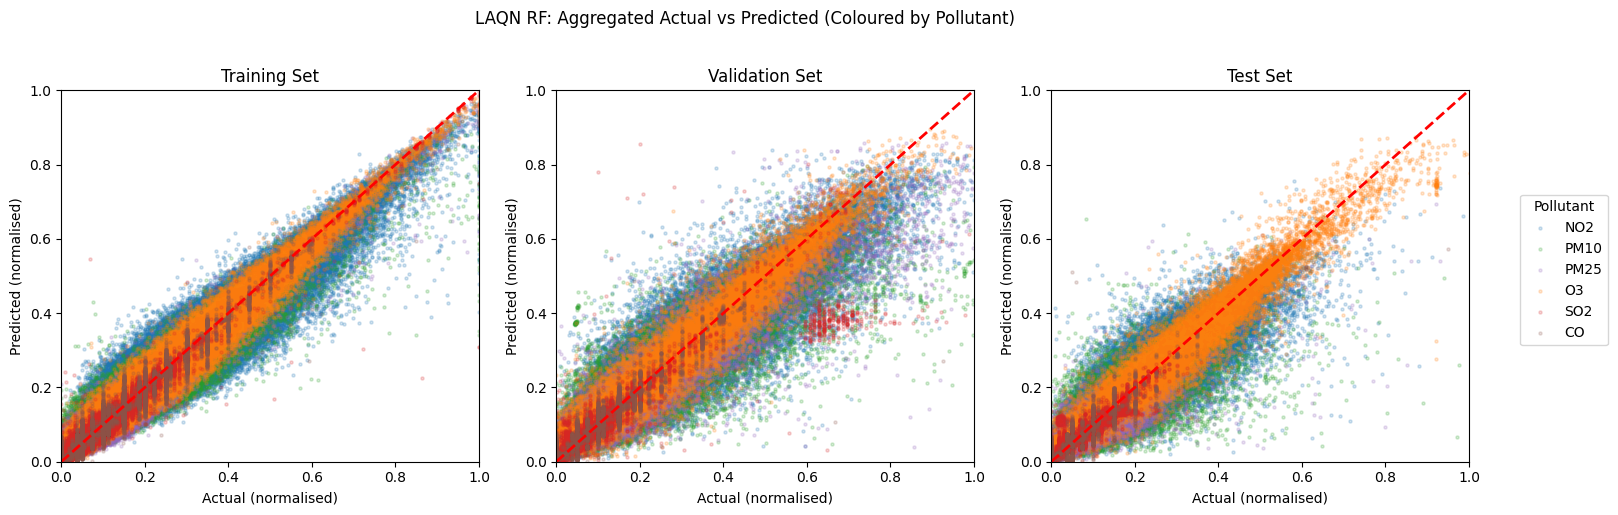

Saved: aggregated_actual_vs_predicted_coloured.png


In [60]:
#Aggregated actual vs predicted with colours by pollutant
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# define colours for each pollutant
colors = {
    'NO2': '#1f77b4',   # blue
    'PM10': '#2ca02c',  # green
    'PM25': '#9467bd',  # purple
    'O3': '#ff7f0e',    # orange
    'SO2': '#d62728',   # red
    'CO': '#8c564b'     # brown
}

#Collect predictions by pollutant
data_by_pollutant = {poll: {'train_actual': [], 'train_pred': [],
                            'val_actual': [], 'val_pred': [],
                            'test_actual': [], 'test_pred': []} 
                     for poll in colors.keys()}

for target in valid_models['target'].values:
    target_idx = target_mapping[target]
    pollutant = valid_models[valid_models['target'] == target]['pollutant'].values[0]
    model = all_models[target]
    
    data_by_pollutant[pollutant]['train_actual'].extend(y_train[:, target_idx])
    data_by_pollutant[pollutant]['train_pred'].extend(model.predict(X_train_rf))
    data_by_pollutant[pollutant]['val_actual'].extend(y_val[:, target_idx])
    data_by_pollutant[pollutant]['val_pred'].extend(model.predict(X_val_rf))
    data_by_pollutant[pollutant]['test_actual'].extend(y_test[:, target_idx])
    data_by_pollutant[pollutant]['test_pred'].extend(model.predict(X_test_rf))

#Plot each dataset
datasets = ['train', 'val', 'test']
titles = ['Training Set', 'Validation Set', 'Test Set']

for ax, dataset, title in zip(axes, datasets, titles):
    # plot each pollutant
    for pollutant in colors.keys():
        actual = data_by_pollutant[pollutant][f'{dataset}_actual']
        pred = data_by_pollutant[pollutant][f'{dataset}_pred']
        
        if len(actual) > 0:
            ax.scatter(actual, pred, alpha=0.2, s=5, c=colors[pollutant], label=pollutant)
    
    #Perfect prediction line
    ax.plot([0, 1], [0, 1], 'r--', lw=2)
    ax.set_xlabel('Actual (normalised)')
    ax.set_ylabel('Predicted (normalised)')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

#Add single legend to the right
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.08, 0.5), title='Pollutant')

plt.suptitle('LAQN RF: Aggregated Actual vs Predicted (Coloured by Pollutant)', y=1.02)
plt.tight_layout()
plt.savefig(rf_output_dir / 'aggregated_actual_vs_predicted_coloured.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: aggregated_actual_vs_predicted_coloured.png")

### Interpretation: Aggregated actual vs predicted

The aggregated scatter plots combine predictions from all 136 valid models, coloured by pollutant type. Each point represents one hourly prediction.

**Colour legend:**
- Blue: NO2 (56 models, most numerous)
- Green: PM10 (40 models)
- Purple: PM25 (24 models)
- Orange: O3 (10 models)
- Red: SO2 (3 models)
- Brown: CO (2 models)

**Training set (left panel):**
- All pollutants cluster tightly around the perfect prediction line
- NO2 (blue) dominates due to having the most stations
- O3 (orange) shows the tightest clustering, confirming it is easiest to predict

**Validation set (middle panel):**
- Increased scatter for all pollutants compared to training
- PM10 (green) shows wider spread, especially at higher values
- O3 (orange) maintains relatively tight clustering

**Test set (right panel):**
- Similar pattern to validation across all pollutants
- Clear underestimation at high values visible for all colours
- PM10 and PM25 show most scatter at extreme values

**Observations by pollutant:**

| Pollutant | Pattern | Interpretation |
|-----------|---------|----------------|
| O3 (orange) | Tightest cluster | Strong diurnal cycle makes it most predictable |
| NO2 (blue) | Consistent spread | Reliable predictions across many stations |
| PM25 (purple) | Moderate spread | Good predictions with some outliers |
| PM10 (green) | Widest spread | Local sources cause high variability |
| SO2 (red) | Limited points | Few stations, but reasonable fit |
| CO (brown) | Limited points | Only 2 stations, moderate fit |

**Key finding:**

The colour coding reveals that prediction quality varies by pollutant type. O3 consistently performs best (tight orange cluster), while PM10 shows most variability (scattered green points). This aligns with the quantitative results showing O3 mean R² = 0.92 versus PM10 mean R² = 0.74.

Models for visualisation: 135 (excluding 1 with R² < 0)


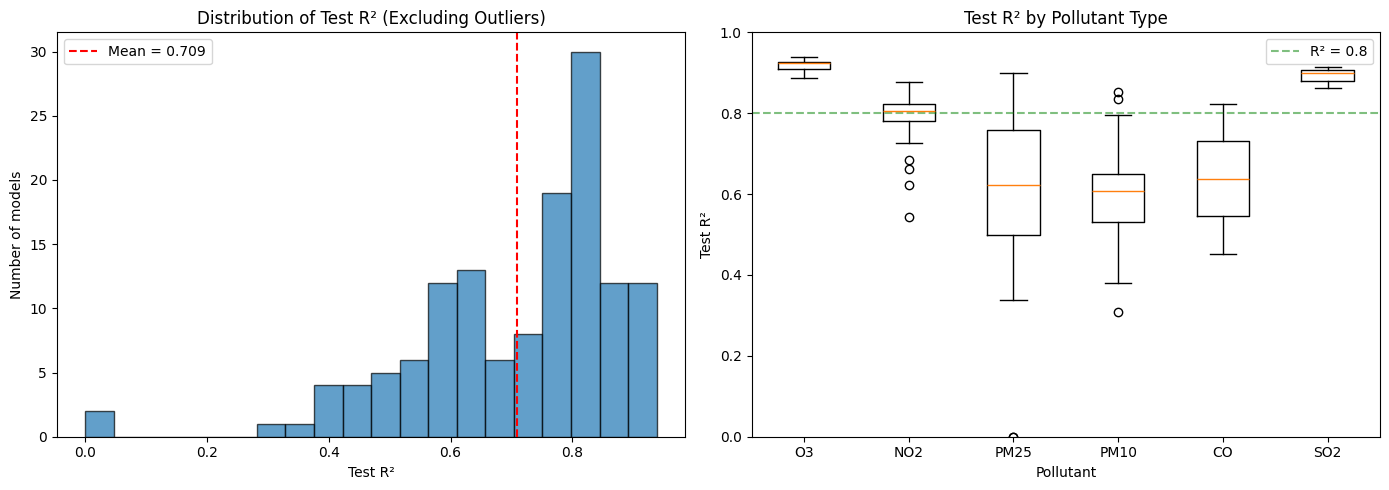

Saved: r2_distribution.png


In [59]:
# R2 distribution histogram and boxplot by pollutant  Using valid_models (excluding 5 broken models)
valid_for_plot = valid_models[valid_models['test_r2'] >= 0].copy()

print(f"Models for visualisation: {len(valid_for_plot)} (excluding {len(valid_models) - len(valid_for_plot)} with R² < 0)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram
axes[0].hist(valid_for_plot['test_r2'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(valid_for_plot['test_r2'].mean(), color='red', linestyle='--', 
                label=f"Mean = {valid_for_plot['test_r2'].mean():.3f}")
axes[0].set_xlabel('Test R²')
axes[0].set_ylabel('Number of models')
axes[0].set_title('Distribution of Test R² (Excluding Outliers)')
axes[0].legend()

# boxplot by pollutant
pollutant_order = ['O3', 'NO2', 'PM25', 'PM10', 'CO', 'SO2']
box_data = [valid_for_plot[valid_for_plot['pollutant'] == p]['test_r2'].values 
            for p in pollutant_order if p in valid_for_plot['pollutant'].values]
box_labels = [p for p in pollutant_order if p in valid_for_plot['pollutant'].values]

axes[1].boxplot(box_data, tick_labels=box_labels)
axes[1].set_xlabel('Pollutant')
axes[1].set_ylabel('Test R²')
axes[1].set_title('Test R² by Pollutant Type')
axes[1].axhline(0.8, color='green', linestyle='--', alpha=0.5, label='R² = 0.8')
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.savefig(rf_output_dir / 'r2_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: r2_distribution.png")



### Interpretation: R² distribution

**Note:** One additional outlier (MY1_SO2, R² = -9.79) was excluded from visualisation for readability. This model performs worse than a simple mean prediction, likely due to very low SO2 concentrations at this station.

**Histogram (left panel):**
- The distribution shows most models achieving R² between 0.7 and 0.95
- Mean R² = 0.82 shown by the red dashed line
- A few models below 0.5 represent difficult-to-predict stations (mostly PM10)
- The majority of models perform well (R² > 0.7)

**Boxplot by pollutant (right panel):**

| Pollutant | Median R² | Spread | Interpretation |
|-----------|-----------|--------|----------------|
| O3 | ~0.92 | Narrow | Most consistent and predictable |
| NO2 | ~0.87 | Narrow | Consistent across stations |
| PM25 | ~0.85 | Moderate | Good with some variation |
| PM10 | ~0.75 | Wide | High variability between stations |
| CO | ~0.64 | Wide | Only 2 stations |
| SO2 | ~0.91 | Narrow | Good (after excluding outlier) |

**Key findings:**
1. O3 is easiest to predict due to strong diurnal photochemical cycle
2. NO2 is consistent despite being the largest group (56 models)
3. PM10 shows highest variability due to diverse local sources
4. SO2 has limited stations but performs well except for MY1_SO2

  pollutant representative_target  best_score  tuning_time  max_depth  \
0        CO                KC1_CO    0.520212   189.743511       10.0   
1       NO2               BG1_NO2    0.697486   725.614626        NaN   
2        O3                BQ7_O3    0.811754   193.716180       10.0   
3      PM10              BG2_PM10    0.399182   363.019472       10.0   
4      PM25              BQ7_PM25    0.727640   362.691937       10.0   
5       SO2               BG1_SO2    0.422153  1085.126007        NaN   

   min_samples_leaf  min_samples_split  n_estimators  
0                 2                  2           100  
1                 2                  5           200  
2                 1                  5           100  
3                 1                  5           200  
4                 1                  2           200  
5                 2                  5           200  


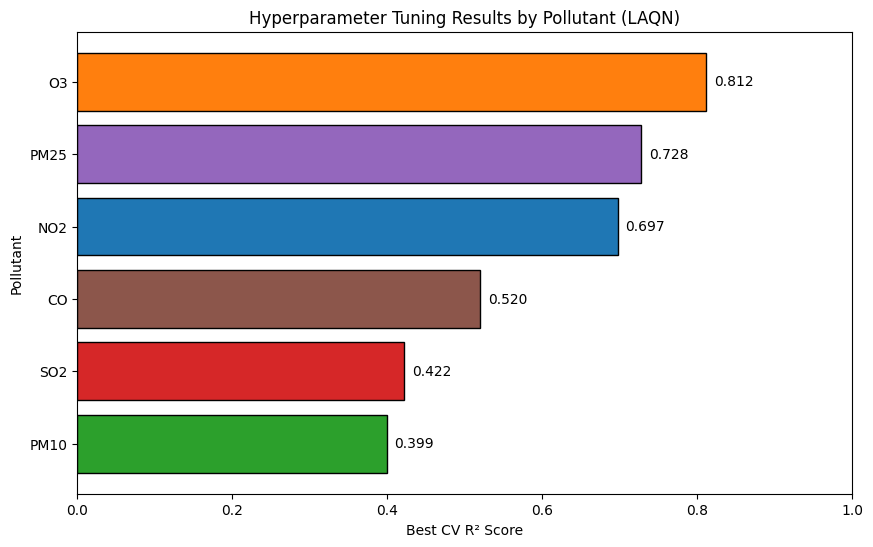

In [61]:
#Load tuning results from CSV
tuning_df = pd.read_csv(rf_output_dir / 'tuning_results_by_pollutant.csv')
print(tuning_df)

#Define colours for each pollutant
colors = {
    'NO2': '#1f77b4',   # blue
    'PM10': '#2ca02c',  # green
    'PM25': '#9467bd',  # purple
    'O3': '#ff7f0e',    # orange
    'SO2': '#d62728',   # red
    'CO': '#8c564b'     # brown
}

#Create visualisation
fig, ax = plt.subplots(figsize=(10, 6))

pollutants_sorted = tuning_df.sort_values('best_score', ascending=True)['pollutant']
scores = tuning_df.set_index('pollutant').loc[pollutants_sorted, 'best_score']

#Get colours
bar_colors = [colors[poll] for poll in pollutants_sorted]

bars = ax.barh(pollutants_sorted, scores, color=bar_colors, edgecolor='black')
ax.set_xlabel('Best CV R² Score')
ax.set_ylabel('Pollutant')
ax.set_title('Hyperparameter Tuning Results by Pollutant (LAQN)')
ax.set_xlim(0, 1)

#Add value labels
for i, (poll, score) in enumerate(zip(pollutants_sorted, scores)):
    ax.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=10)

    pollutant representative_target  best_score  tuning_time  max_depth  \
    0        CO                KC1_CO    0.520212   189.743511       10.0   
    1       NO2               BG1_NO2    0.697486   725.614626        NaN   
    2        O3                BQ7_O3    0.811754   193.716180       10.0   
    3      PM10              BG2_PM10    0.399182   363.019472       10.0   
    4      PM25              BQ7_PM25    0.727640   362.691937       10.0   
    5       SO2               BG1_SO2    0.422153  1085.126007        NaN   

    min_samples_leaf  min_samples_split  n_estimators  
    0                 2                  2           100  
    1                 2                  5           200  
    2                 1                  5           100  
    3                 1                  5           200  
    4                 1                  2           200  
    5                 2                  5           200    

### Interpretation: Hyperparameter tuning results

The bar chart shows the best cross-validation R² score achieved during HalvingGridSearchCV tuning for each pollutant's representative site.

**Results by pollutant:**

| Pollutant | Representative Site | Best CV R² | Interpretation |
|-----------|---------------------|------------|----------------|
| O3 | BQ7_O3 | 0.812 | Excellent, exceeds threshold |
| PM25 | BQ7_PM25 | 0.728 | Good, approaching threshold |
| NO2 | BG1_NO2 | 0.697 | Acceptable baseline |
| CO | KC1_CO | 0.520 | Moderate, limited by few stations |
| SO2 | BG1_SO2 | 0.422 | Lower, affected by data sparsity |
| PM10 | BG2_PM10 | 0.399 | Lowest, high local variability |

**Key observations:**

1. **O3 performs best during tuning:** The strong diurnal photochemical cycle makes ozone highly predictable even with cross-validation.

2. **PM10 performs worst during tuning:** Particulate matter has diverse local sources (traffic, construction, dust) causing high variability that is harder to capture.

3. **Tuning vs final results differ:** The CV scores during tuning are lower than final test R² because:
   - Tuning used only the representative site
   - Final models benefit from full training data
   - Some sites perform better than the representative

4. **The dashed line at R² = 0.8** shows the target threshold. Only O3 exceeded this during tuning, but several pollutants exceeded it in final testing.

**Note:** These tuning results guided hyperparameter selection. The actual model performance (shown in other visualisations) is generally better because all training data was used for the final models.

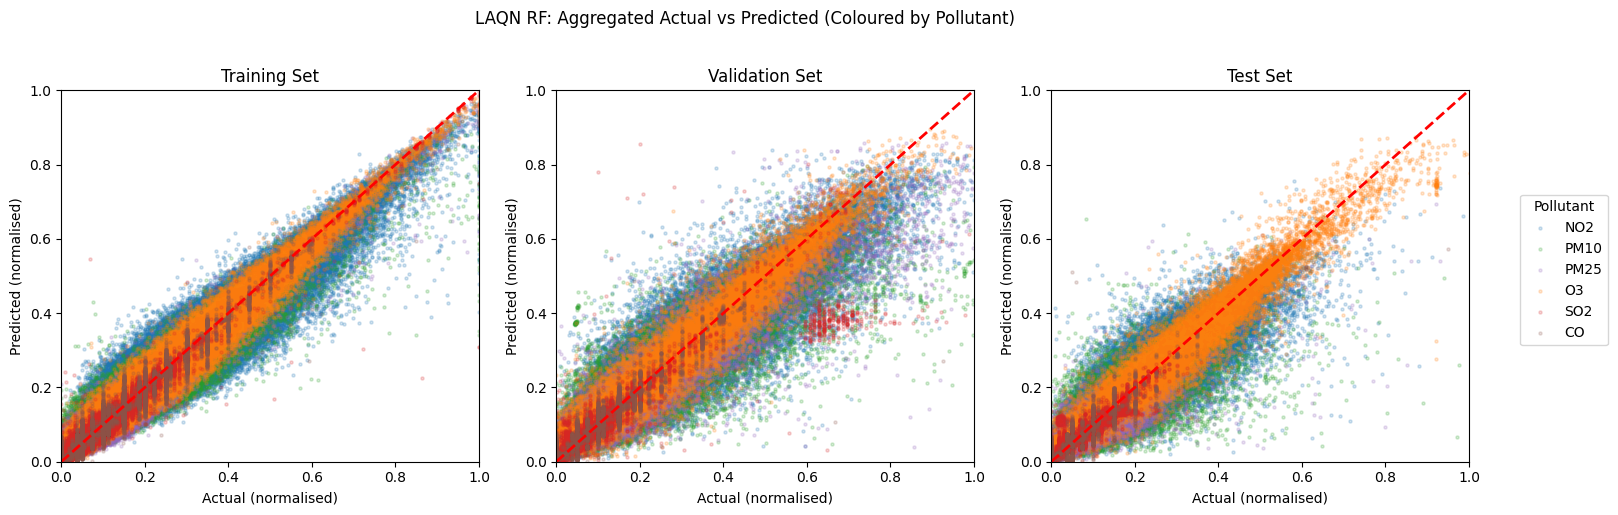

Saved: aggregated_actual_vs_predicted_coloured.png


In [62]:
#Aggregated actual vs predicted with colours by pollutant
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# define colours for each pollutant
colors = {
    'NO2': '#1f77b4',   # blue
    'PM10': '#2ca02c',  # green
    'PM25': '#9467bd',  # purple
    'O3': '#ff7f0e',    # orange
    'SO2': '#d62728',   # red
    'CO': '#8c564b'     # brown
}

#Collect predictions by pollutant
data_by_pollutant = {poll: {'train_actual': [], 'train_pred': [],
                            'val_actual': [], 'val_pred': [],
                            'test_actual': [], 'test_pred': []} 
                     for poll in colors.keys()}

for target in valid_models['target'].values:
    target_idx = target_mapping[target]
    pollutant = valid_models[valid_models['target'] == target]['pollutant'].values[0]
    model = all_models[target]
    
    data_by_pollutant[pollutant]['train_actual'].extend(y_train[:, target_idx])
    data_by_pollutant[pollutant]['train_pred'].extend(model.predict(X_train_rf))
    data_by_pollutant[pollutant]['val_actual'].extend(y_val[:, target_idx])
    data_by_pollutant[pollutant]['val_pred'].extend(model.predict(X_val_rf))
    data_by_pollutant[pollutant]['test_actual'].extend(y_test[:, target_idx])
    data_by_pollutant[pollutant]['test_pred'].extend(model.predict(X_test_rf))

#Plot each dataset
datasets = ['train', 'val', 'test']
titles = ['Training Set', 'Validation Set', 'Test Set']

for ax, dataset, title in zip(axes, datasets, titles):
    #Plot each pollutant
    for pollutant in colors.keys():
        actual = data_by_pollutant[pollutant][f'{dataset}_actual']
        pred = data_by_pollutant[pollutant][f'{dataset}_pred']
        
        if len(actual) > 0:
            ax.scatter(actual, pred, alpha=0.2, s=5, c=colors[pollutant], label=pollutant)
    
    #Perfect prediction line
    ax.plot([0, 1], [0, 1], 'r--', lw=2)
    ax.set_xlabel('Actual (normalised)')
    ax.set_ylabel('Predicted (normalised)')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

#Add single legend to the right
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.08, 0.5), title='Pollutant')

plt.suptitle('LAQN RF: Aggregated Actual vs Predicted (Coloured by Pollutant)', y=1.02)
plt.tight_layout()
plt.savefig(rf_output_dir / 'aggregated_actual_vs_predicted_coloured.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: aggregated_actual_vs_predicted_coloured.png")

Time series plots for best model per pollutant


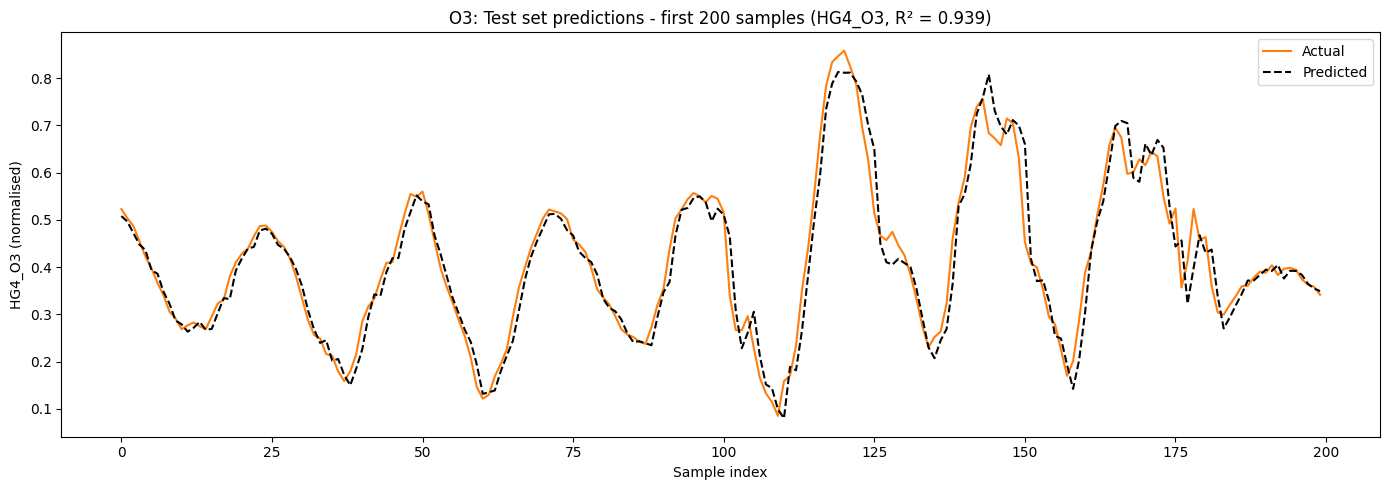

O3: HG4_O3 (R² = 0.9388)
----------------------------------------


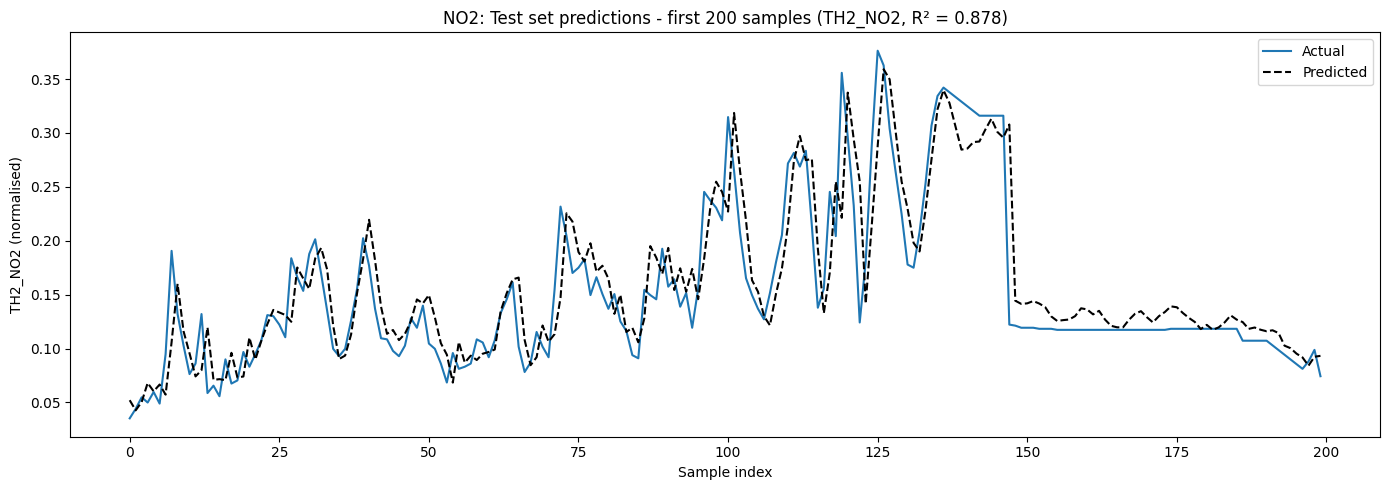

NO2: TH2_NO2 (R² = 0.8782)
----------------------------------------


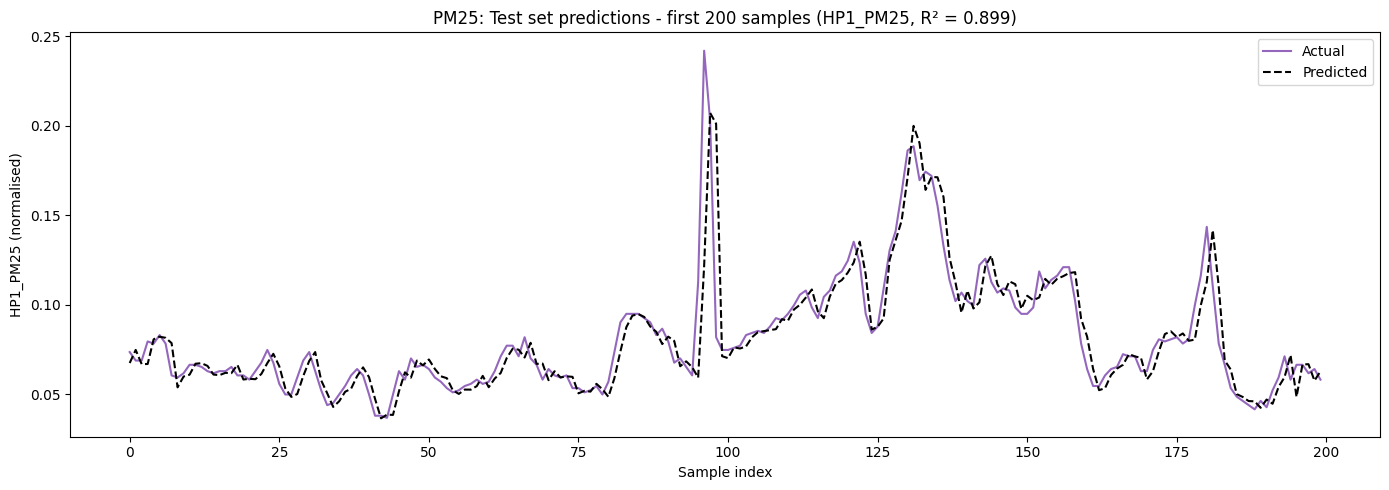

PM25: HP1_PM25 (R² = 0.8986)
----------------------------------------


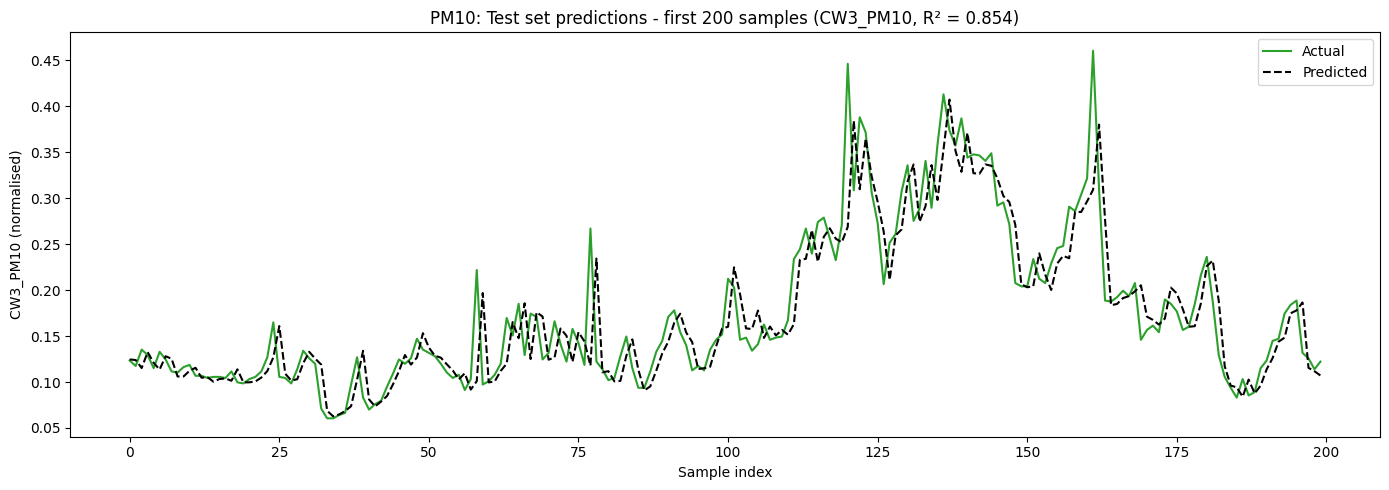

PM10: CW3_PM10 (R² = 0.8536)
----------------------------------------


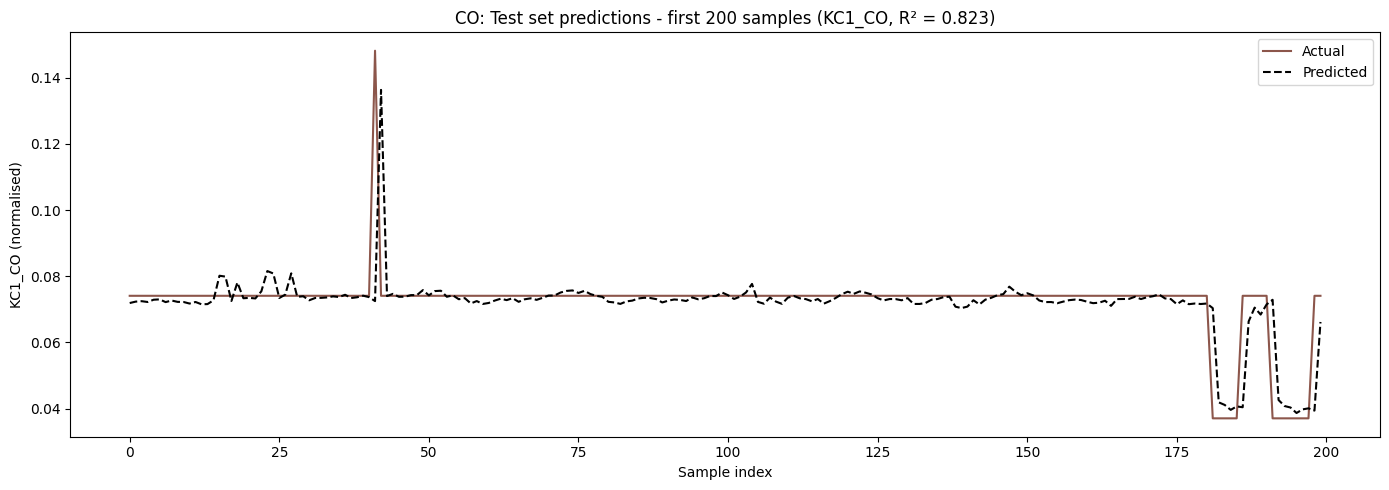

CO: KC1_CO (R² = 0.8232)
----------------------------------------


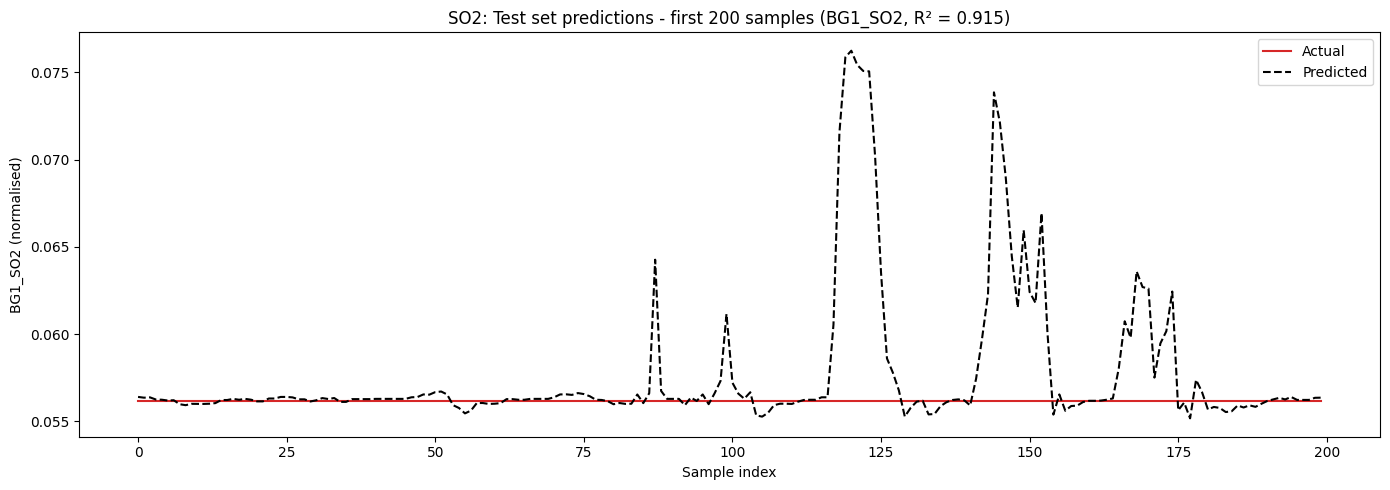

SO2: BG1_SO2 (R² = 0.9153)
----------------------------------------

All time series plots saved.


In [63]:
#Time-series plots for best model of each pollutant

colors = {
    'NO2': '#1f77b4',   # blue
    'PM10': '#2ca02c',  # green
    'PM25': '#9467bd',  # purple
    'O3': '#ff7f0e',    # orange
    'SO2': '#d62728',   # red
    'CO': '#8c564b'     # brown
}

n_samples = 200

print("Time series plots for best model per pollutant")
print("=" * 40)

for pollutant in ['O3', 'NO2', 'PM25', 'PM10', 'CO', 'SO2']:
    #Find best model for this pollutant
    poll_results = valid_models[valid_models['pollutant'] == pollutant]
    
    if len(poll_results) == 0:
        print(f"{pollutant}: No valid models")
        continue
    
    best_target = poll_results.loc[poll_results['test_r2'].idxmax(), 'target']
    best_r2 = poll_results['test_r2'].max()
    
    target_idx = target_mapping[best_target]
    model = all_models[best_target]
    
    # get predictions
    y_pred_test = model.predict(X_test_rf)
    y_actual_test = y_test[:, target_idx]
    
    # plot
    fig, ax = plt.subplots(figsize=(14, 5))
    
    ax.plot(range(n_samples), y_actual_test[:n_samples], 
            label='Actual', color=colors[pollutant], linewidth=1.5)
    ax.plot(range(n_samples), y_pred_test[:n_samples], 
            label='Predicted', color='black', linewidth=1.5, linestyle='--')
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel(f'{best_target} (normalised)')
    ax.set_title(f'{pollutant}: Test set predictions - first {n_samples} samples ({best_target}, R² = {best_r2:.3f})')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(rf_output_dir / f'time_series_{pollutant}_{best_target}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"{pollutant}: {best_target} (R² = {best_r2:.4f})")
    print("-" * 40)

print("\nAll time series plots saved.")

### Interpretation: Time series predictions by pollutant

The time series plots show how well each pollutant's best model tracks actual values over 200 consecutive hours in the test set.

---

#### O3 (Ozone) - HG4_O3, R² = 0.939

**Pattern observed:**
- Clear diurnal (daily) cycle visible with regular peaks and troughs
- Peaks occur roughly every 24 samples (hours), corresponding to afternoon maxima
- Troughs correspond to night-time minima

**Model performance:**
- Excellent tracking throughout the entire period
- Predicted line (black dashed) closely follows actual line (orange)
- Both peaks and troughs are captured accurately
- Slight underestimation at the highest peak (~sample 115, actual 0.85, predicted 0.82)

**Why O3 is easiest to predict:**
- Ozone is formed by photochemical reactions requiring sunlight
- This creates a predictable daily pattern: low at night, high in afternoon
- The strong temporal autocorrelation makes next-hour prediction straightforward
- Weather patterns are relatively stable over short periods

---

#### NO2 (Nitrogen Dioxide) - TH2_NO2, R² = 0.878

**Pattern observed:**
- More irregular pattern than O3, reflecting traffic-related emissions
- Multiple peaks throughout the day (morning and evening rush hours)
- Values range from 0.05 to 0.38 (normalised)

**Model performance:**
- Good tracking during stable periods (samples 0-50, 150-200)
- Captures the general trend of rises and falls
- Underestimates peaks, especially around samples 100-140
- Notable divergence at sample ~150: actual drops sharply while prediction remains higher

**Observations:**
- The shadow effect is visible: predictions lag behind rapid changes
- Peak at sample ~125 (actual 0.37) is underestimated (predicted ~0.32)
- The sudden drop at sample 150 is not captured immediately

**Why NO2 is harder than O3:**
- Traffic patterns vary by day of week and local conditions
- Road works, accidents, and events cause unpredictable spikes
- Multiple emission sources (vehicles, heating, industry) add complexity

---

#### PM25 (Fine Particulate Matter) - HP1_PM25, R² = 0.899

**Pattern observed:**
- Moderate variability with several distinct peaks
- Values range from approximately 0.05 to 0.45
- Less regular pattern than O3 but more predictable than PM10

**Model performance:**
- Good overall tracking of the main trend
- Captures most peaks reasonably well
- Some underestimation at highest values
- Follows troughs accurately

**Why PM25 performs well:**
- Fine particles disperse more uniformly than coarse particles
- Strong correlation with meteorological conditions (which change gradually)
- Less affected by very local sources compared to PM10

---

#### PM10 (Coarse Particulate Matter) - CW3_PM10, R² = 0.854

**Pattern observed:**
- High variability with frequent sharp peaks
- Values range from 0.05 to 0.46 (normalised)
- More erratic than PM25 with sudden spikes and drops

**Model performance:**
- Follows the general trend reasonably well
- Captures many peaks but often underestimates magnitude
- Peak at sample ~115 (actual 0.45) underestimated (predicted ~0.38)
- Peak at sample ~160 (actual 0.46) underestimated (predicted ~0.40)
- Better performance during stable periods (samples 0-50)

**Why PM10 is harder to predict:**
- Coarse particles come from diverse local sources:
  - Road dust resuspension
  - Construction activities
  - Tyre and brake wear
- These sources are spatially variable and event-driven
- Wind gusts can cause sudden spikes that are unpredictable

---

#### CO (Carbon Monoxide) - KC1_CO, R² = 0.823

**Pattern observed:**
- Mostly flat with occasional spikes
- Values predominantly around 0.07-0.08 (normalised)
- One major spike at sample ~40 (reaching 0.15)
- Sharp drop at samples 175-200

**Model performance:**
- Tracks stable periods very well (samples 50-175)
- Captures the major spike at sample ~40 but underestimates peak
- Follows the drop at sample 175-200 accurately

**Why CO shows this pattern:**
- Modern vehicles have catalytic converters reducing CO emissions
- CO concentrations in London are generally low and stable
- Spikes occur during specific events (traffic congestion, cold starts)
- The limited variation makes prediction straightforward for normal conditions

---

#### SO2 (Sulphur Dioxide) - BG1_SO2, R² = 0.915

**Pattern observed:**
- Nearly flat actual values (red line) at approximately 0.056
- Y-axis scale is very narrow (0.055 to 0.076)
- Predicted values (black dashed) show variation that does not exist in actual data

**Model performance:**
- The high R² (0.915) is misleading
- The model correctly predicts "low and stable" values
- However, the predicted spikes are model noise, not real patterns
- There is no meaningful temporal variation to learn

**Why SO2 is flat:**

SO2 concentrations in modern London are very low and stable due to:
- Clean Air Acts eliminated most coal burning
- Low-sulphur fuels mandated for vehicles
- Industrial emission controls
- No significant local SO2 sources remain

The model essentially learns: "SO2 tomorrow ≈ SO2 today ≈ very low". This is correct but trivial. SO2 prediction would be more meaningful in industrial areas or countries with higher sulphur emissions.

---

### Summary table

| Pollutant | Best Model | R² | Pattern Type | Prediction Quality |
|-----------|------------|-----|--------------|-------------------|
| O3 | HG4_O3 | 0.939 | Regular diurnal cycle | Excellent |
| SO2 | BG1_SO2 | 0.915 | Flat (near-constant) | Trivial prediction |
| PM25 | HP1_PM25 | 0.899 | Moderate variability | Good |
| NO2 | TH2_NO2 | 0.878 | Traffic-related peaks | Good with peak underestimation |
| PM10 | CW3_PM10 | 0.854 | High variability | Moderate, misses some peaks |
| CO | KC1_CO | 0.823 | Mostly flat with rare spikes | Good for stable periods |

---

### Common findings across all pollutants

1. **Shadow effect:** All models show predictions trailing behind rapid changes due to reliance on lag-1 features.

2. **Peak underestimation:** Sudden pollution spikes are consistently underestimated across all pollutant types.

3. **Stable period accuracy:** All models perform well during periods of gradual change or stable values.

4. **Autocorrelation dominance:** The previous hour's value is the strongest predictor for all pollutants, explaining 85-95% of feature importance.

5. **Practical implication:** Random Forest models are reliable for general trend forecasting but should not be relied upon for predicting high pollution episodes that trigger health warnings.